In [20]:
import os, time
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam, SGD
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Dataset

The dataset consists of labeled images organized into class folders and loaded using `ImageFolder`.

The data is split into training, validation, and test sets:
- Training set: used for model learning
- Validation set: used for hyperparameter tuning
- Test set: used for final evaluation

### Preprocessing

All images are resized and cropped to a fixed size of 224×224 pixels.

Normalization is applied using ImageNet statistics:
- mean = [0.485, 0.456, 0.406]
- std  = [0.229, 0.224, 0.225]


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import Subset
import torch

DATA_DIR = "data/dogs"

def load_dataset(val_split=0.2, test_ratio=0.2, seed=42):
    transform_train = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    transform_test = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    ds_train = datasets.ImageFolder(root=DATA_DIR, transform=transform_train)
    ds_test  = datasets.ImageFolder(root=DATA_DIR, transform=transform_test)

    n = len(ds_train)
    test_size = int(n * test_ratio)
    trainval_size = n - test_size

    g = None
    if seed is not None:
        g = torch.Generator().manual_seed(seed)
        perm = torch.randperm(n, generator=g).tolist()
    else:
        perm = torch.randperm(n).tolist()

    test_idx = perm[:test_size]
    trainval_idx = perm[test_size:]

    val_size = int(trainval_size * val_split)
    val_idx = trainval_idx[:val_size]
    train_idx = trainval_idx[val_size:]

    train_set = Subset(ds_train, train_idx)
    val_set   = Subset(ds_test,  val_idx)
    test_set  = Subset(ds_test,  test_idx)

    return train_set, val_set, test_set


In [24]:
train_set, val_set, test_set = load_dataset(val_split=0.2, seed=42)

train_loader = DataLoader(train_set, batch_size=8, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_set,   batch_size=8, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_set,  batch_size=8, shuffle=False, num_workers=2, pin_memory=True)



In [25]:
print("Train:", len(train_set))
print("Val:", len(val_set))
print("Test:", len(test_set))

base_ds = train_set.dataset
print("Classes:", base_ds.classes)
print("Num classes:", len(base_ds.classes))

Train: 392
Val: 98
Test: 122
Classes: ['Border_collie', 'German_shepherd', 'boxer', 'poodle']
Num classes: 4


In [26]:
NUM_CLASSES = 4

class ShallowCNN(nn.Module):
    def __init__(self):
        super(ShallowCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )

        self.fc = nn.Sequential(
            nn.Linear(128 * 28 * 28, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, NUM_CLASSES)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [27]:

class DeeperCNN(nn.Module):
    def __init__(self):
        super(DeeperCNN, self).__init__()

        self.features = nn.Sequential(
            # Block 1: 224 -> 112
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            # Block 2: 112 -> 56
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            # Block 3: 56 -> 28
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, NUM_CLASSES)

        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x



In [28]:
import copy

def train(net, train_loader, val_loader, criterion, optimizer, epochs, device):
    net.to(device)
    best_val_acc = 0.0
    best_state = None

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(epochs):
        net.train()
        train_loss_sum = 0.0
        train_correct = 0
        train_total = 0

        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = net(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            bs = target.size(0)
            train_loss_sum += loss.item() * bs
            train_correct += (output.argmax(1) == target).sum().item()
            train_total += bs

        train_loss = train_loss_sum / train_total
        train_acc  = 100.0 * train_correct / train_total

        net.eval()
        val_loss_sum = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = net(data)
                loss = criterion(output, target)

                bs = target.size(0)
                val_loss_sum += loss.item() * bs
                val_correct += (output.argmax(1) == target).sum().item()
                val_total += bs

        val_loss = val_loss_sum / val_total
        val_acc  = 100.0 * val_correct / val_total

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = copy.deepcopy(net.state_dict())

        print(f"Epoch {epoch+1:02d}/{epochs} | "
              f"train loss {train_loss:.4f} acc {train_acc:.1f}% | "
              f"val loss {val_loss:.4f} acc {val_acc:.1f}% | "
              f"best {best_val_acc:.1f}%")

    if best_state is not None:
        net.load_state_dict(best_state)

    return best_val_acc, history


def accuracy(net, loader):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            predicted = outputs.argmax(dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100.0 * correct / total


In [29]:
import matplotlib.pyplot as plt

def plot_history(history, title=""):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(6,4))
    plt.plot(epochs, history["train_loss"], label="train loss")
    plt.plot(epochs, history["val_loss"], label="val loss")
    plt.title("Loss " + title)
    plt.xlabel("epoch"); plt.ylabel("loss")
    plt.legend()
    plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(epochs, history["train_acc"], label="train acc")
    plt.plot(epochs, history["val_acc"], label="val acc")
    plt.title("Accuracy " + title)
    plt.xlabel("epoch"); plt.ylabel("accuracy (%)")
    plt.legend()
    plt.show()


In [30]:
results = []


## Part 1 - Step 1: Architecture & Optimization

I implemented two CNN architectures:

- **ShallowCNN**: 3 convolution blocks (Conv→ReLU→MaxPool) followed by a small fully-connected head.
- **DeeperCNN**: VGG-style design with 2 convolutions per block, aiming to learn richer features.

I compared optimizers (Adam vs SGD+momentum) and tuned key hyperparameters:
- learning rate
- number of epochs
- batch size

EXPERIMENT 1

Epoch 01/10 | train loss 1.5423 acc 29.3% | val loss 1.3493 acc 36.7% | best 36.7%
Epoch 02/10 | train loss 1.3321 acc 35.7% | val loss 1.3688 acc 30.6% | best 36.7%
Epoch 03/10 | train loss 1.2860 acc 41.8% | val loss 1.4335 acc 38.8% | best 38.8%
Epoch 04/10 | train loss 1.3182 acc 40.1% | val loss 1.2244 acc 46.9% | best 46.9%
Epoch 05/10 | train loss 1.2321 acc 49.0% | val loss 1.1612 acc 43.9% | best 46.9%
Epoch 06/10 | train loss 1.2372 acc 46.2% | val loss 1.1410 acc 49.0% | best 49.0%
Epoch 07/10 | train loss 1.2074 acc 47.4% | val loss 1.1334 acc 51.0% | best 51.0%
Epoch 08/10 | train loss 1.2303 acc 48.2% | val loss 1.1050 acc 56.1% | best 56.1%
Epoch 09/10 | train loss 1.1607 acc 49.7% | val loss 1.1419 acc 53.1% | best 56.1%
Epoch 10/10 | train loss 1.2086 acc 49.0% | val loss 1.2103 acc 43.9% | best 56.1%


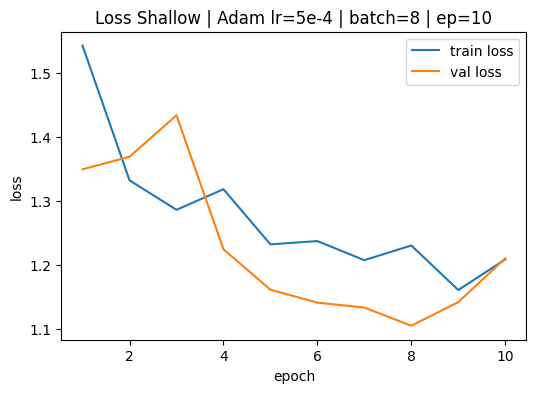

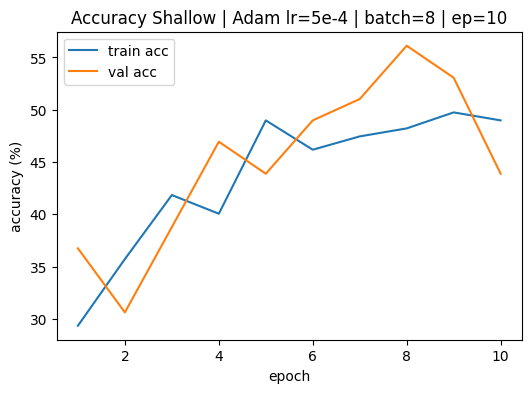

Best val acc (Shallow): 56.12244897959184


In [31]:
import torch.nn as nn
import torch.optim as optim

net_shallow = ShallowCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net_shallow.parameters(), lr=0.0005)

best_val_shallow, hist = train(
    net_shallow,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    epochs=10,
    device=device
)
plot_history(hist, "Shallow | Adam lr=5e-4 | batch=8 | ep=10")

results.append(("Shallow", "Adam", 5e-4, 8, 10, best_val_shallow))

print("Best val acc (Shallow):", best_val_shallow)


EXPERIMENT 2

Epoch 01/10 | train loss 1.4041 acc 26.8% | val loss 1.3452 acc 35.7% | best 35.7%
Epoch 02/10 | train loss 1.3456 acc 37.8% | val loss 1.2862 acc 50.0% | best 50.0%
Epoch 03/10 | train loss 1.3041 acc 40.6% | val loss 1.2401 acc 40.8% | best 50.0%
Epoch 04/10 | train loss 1.2638 acc 41.3% | val loss 1.1916 acc 46.9% | best 50.0%
Epoch 05/10 | train loss 1.2704 acc 43.9% | val loss 1.2000 acc 51.0% | best 51.0%
Epoch 06/10 | train loss 1.2019 acc 49.5% | val loss 1.2272 acc 42.9% | best 51.0%
Epoch 07/10 | train loss 1.1906 acc 49.2% | val loss 1.1490 acc 44.9% | best 51.0%
Epoch 08/10 | train loss 1.1611 acc 48.7% | val loss 1.1048 acc 52.0% | best 52.0%
Epoch 09/10 | train loss 1.1773 acc 50.8% | val loss 1.1464 acc 51.0% | best 52.0%
Epoch 10/10 | train loss 1.1512 acc 50.3% | val loss 1.0811 acc 50.0% | best 52.0%


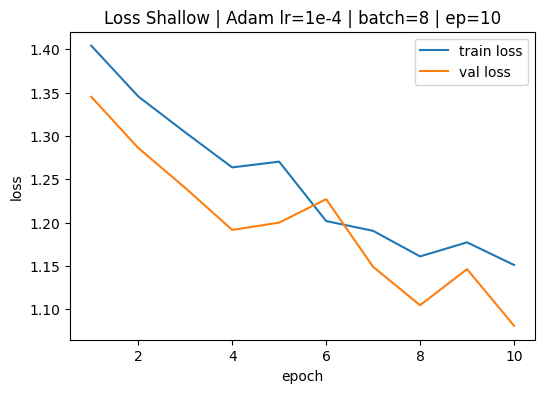

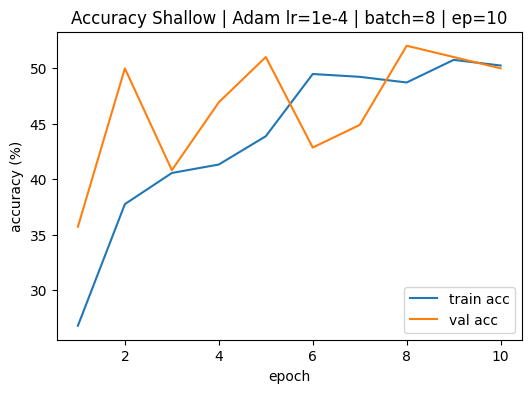

Best val acc (Shallow): 52.04081632653061


In [32]:
import torch.nn as nn
import torch.optim as optim

net_shallow = ShallowCNN().to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net_shallow.parameters(), lr=0.0001)


best_val_shallow, hist = train(
    net_shallow,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    epochs=10,
    device=device
)
plot_history(hist, "Shallow | Adam lr=1e-4 | batch=8 | ep=10")

results.append(("Shallow", "Adam", 1e-4, 8, 10, best_val_shallow))
print("Best val acc (Shallow):", best_val_shallow)


EXPERIMENT 3

Epoch 01/10 | train loss 1.5799 acc 27.0% | val loss 1.4158 acc 31.6% | best 31.6%
Epoch 02/10 | train loss 1.3881 acc 29.3% | val loss 1.3333 acc 38.8% | best 38.8%
Epoch 03/10 | train loss 1.3842 acc 27.6% | val loss 1.3488 acc 28.6% | best 38.8%
Epoch 04/10 | train loss 1.3705 acc 33.4% | val loss 1.2962 acc 45.9% | best 45.9%
Epoch 05/10 | train loss 1.3338 acc 39.3% | val loss 1.2746 acc 41.8% | best 45.9%
Epoch 06/10 | train loss 1.2845 acc 42.6% | val loss 1.2397 acc 46.9% | best 46.9%
Epoch 07/10 | train loss 1.2934 acc 42.3% | val loss 1.2196 acc 49.0% | best 49.0%
Epoch 08/10 | train loss 1.2343 acc 47.4% | val loss 1.2990 acc 34.7% | best 49.0%
Epoch 09/10 | train loss 1.2155 acc 46.7% | val loss 1.1147 acc 52.0% | best 52.0%
Epoch 10/10 | train loss 1.2272 acc 46.9% | val loss 1.1322 acc 49.0% | best 52.0%


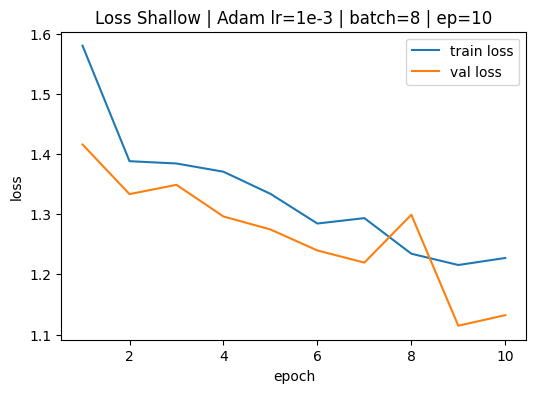

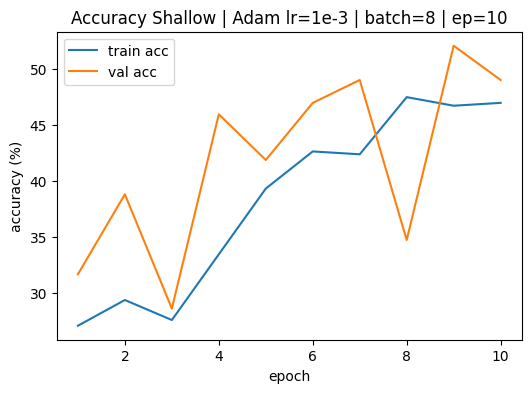

Best val acc (Shallow): 52.04081632653061


In [33]:
import torch.nn as nn
import torch.optim as optim


net_shallow = ShallowCNN().to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net_shallow.parameters(), lr=0.001)


best_val_shallow, hist = train(
    net_shallow,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    epochs=10,
    device=device
)
plot_history(hist, "Shallow | Adam lr=1e-3 | batch=8 | ep=10")

results.append(("Shallow", "Adam", 1e-3, 8, 10, best_val_shallow))
print("Best val acc (Shallow):", best_val_shallow)


EXPERIMENT 4

Epoch 01/10 | train loss 1.3994 acc 25.0% | val loss 1.3862 acc 23.5% | best 23.5%
Epoch 02/10 | train loss 1.3811 acc 30.1% | val loss 1.3805 acc 26.5% | best 26.5%
Epoch 03/10 | train loss 1.3678 acc 29.8% | val loss 1.2725 acc 44.9% | best 44.9%
Epoch 04/10 | train loss 1.3409 acc 36.5% | val loss 1.3023 acc 35.7% | best 44.9%
Epoch 05/10 | train loss 1.3612 acc 31.1% | val loss 1.3182 acc 39.8% | best 44.9%
Epoch 06/10 | train loss 1.3232 acc 37.8% | val loss 1.3379 acc 30.6% | best 44.9%
Epoch 07/10 | train loss 1.3336 acc 34.7% | val loss 1.5089 acc 31.6% | best 44.9%
Epoch 08/10 | train loss 1.3690 acc 33.2% | val loss 1.3122 acc 38.8% | best 44.9%
Epoch 09/10 | train loss 1.3245 acc 34.2% | val loss 1.3114 acc 38.8% | best 44.9%
Epoch 10/10 | train loss 1.2901 acc 35.2% | val loss 1.2629 acc 40.8% | best 44.9%


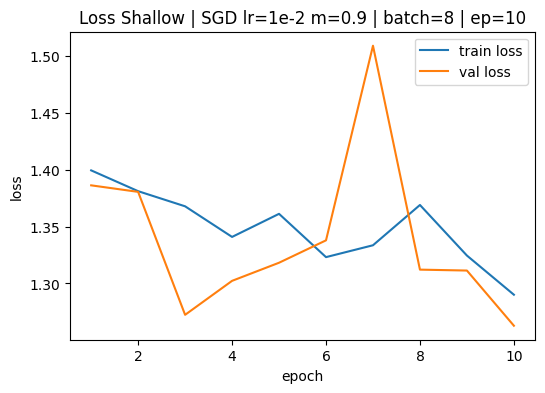

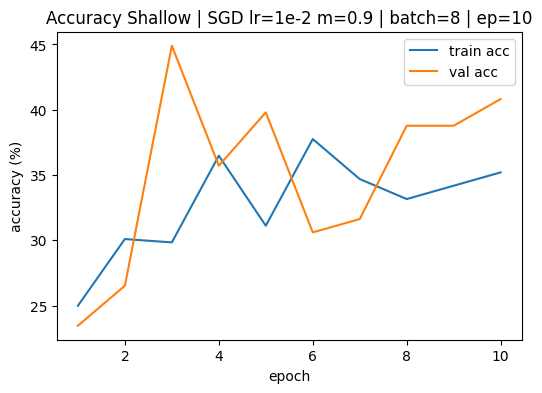

Best val acc (Shallow + SGD + lr = 3e-2): 44.89795918367347


In [34]:
import torch.nn as nn
import torch.optim as optim

net_shallow_sgd = ShallowCNN().to(device)

criterion = nn.CrossEntropyLoss()

optimizer_sgd = optim.SGD(net_shallow_sgd.parameters(), lr=0.01, momentum=0.9)

best_val_shallow_sgd, hist = train(
    net_shallow_sgd,
    train_loader,
    val_loader,
    criterion,
    optimizer_sgd,
    epochs=10,
    device=device
)
plot_history(hist, "Shallow | SGD lr=1e-2 m=0.9 | batch=8 | ep=10")

results.append(("Shallow", "SGD_mom", 1e-2, 8, 10, best_val_shallow_sgd))
print("Best val acc (Shallow + SGD + lr = 3e-2):", best_val_shallow_sgd)

EXPERIMENT 5

Epoch 01/10 | train loss 1.3953 acc 27.3% | val loss 1.3762 acc 29.6% | best 29.6%
Epoch 02/10 | train loss 1.3632 acc 31.6% | val loss 1.3312 acc 30.6% | best 30.6%
Epoch 03/10 | train loss 1.3749 acc 32.4% | val loss 1.3556 acc 41.8% | best 41.8%
Epoch 04/10 | train loss 1.3628 acc 34.9% | val loss 1.2996 acc 43.9% | best 43.9%
Epoch 05/10 | train loss 1.3522 acc 36.2% | val loss 1.3243 acc 39.8% | best 43.9%
Epoch 06/10 | train loss 1.3635 acc 33.7% | val loss 1.2791 acc 43.9% | best 43.9%
Epoch 07/10 | train loss 1.3219 acc 38.3% | val loss 1.2334 acc 43.9% | best 43.9%
Epoch 08/10 | train loss 1.3097 acc 41.8% | val loss 1.2889 acc 41.8% | best 43.9%
Epoch 09/10 | train loss 1.2678 acc 42.3% | val loss 1.2042 acc 44.9% | best 44.9%
Epoch 10/10 | train loss 1.2752 acc 44.4% | val loss 1.2279 acc 49.0% | best 49.0%


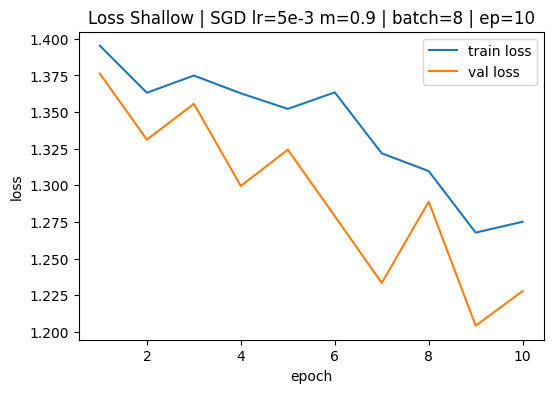

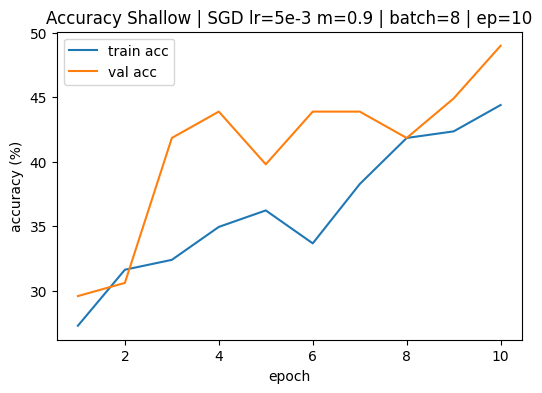

Best val acc (Shallow + SGD + lr = 0.005): 48.97959183673469


In [35]:
import torch.nn as nn
import torch.optim as optim

net_shallow_sgd = ShallowCNN().to(device)

criterion = nn.CrossEntropyLoss()

optimizer_sgd = optim.SGD(net_shallow_sgd.parameters(), lr=0.005, momentum=0.9)

best_val_shallow_sgd, hist = train(
    net_shallow_sgd,
    train_loader,
    val_loader,
    criterion,
    optimizer_sgd,
    epochs=10,
    device=device
)
plot_history(hist, "Shallow | SGD lr=5e-3 m=0.9 | batch=8 | ep=10")

results.append(("Shallow", "SGD_mom", 5e-3, 8, 10, best_val_shallow_sgd))
print("Best val acc (Shallow + SGD + lr = 0.005):", best_val_shallow_sgd)

EXPERIMENT 6

Epoch 01/10 | train loss 1.3924 acc 20.9% | val loss 1.3868 acc 22.4% | best 22.4%
Epoch 02/10 | train loss 1.3911 acc 24.5% | val loss 1.3894 acc 21.4% | best 22.4%
Epoch 03/10 | train loss 1.3898 acc 21.9% | val loss 1.3887 acc 35.7% | best 35.7%
Epoch 04/10 | train loss 1.3876 acc 25.8% | val loss 1.3817 acc 38.8% | best 38.8%
Epoch 05/10 | train loss 1.3894 acc 29.3% | val loss 1.3801 acc 33.7% | best 38.8%
Epoch 06/10 | train loss 1.3854 acc 25.3% | val loss 1.3877 acc 29.6% | best 38.8%
Epoch 07/10 | train loss 1.3924 acc 23.5% | val loss 1.3874 acc 22.4% | best 38.8%
Epoch 08/10 | train loss 1.3897 acc 21.4% | val loss 1.3918 acc 22.4% | best 38.8%
Epoch 09/10 | train loss 1.3919 acc 21.2% | val loss 1.3877 acc 22.4% | best 38.8%
Epoch 10/10 | train loss 1.3894 acc 24.0% | val loss 1.3877 acc 21.4% | best 38.8%


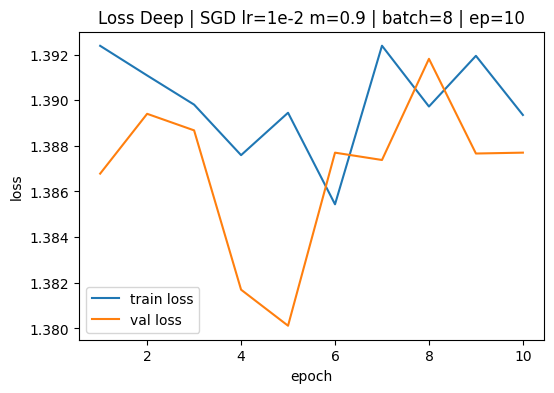

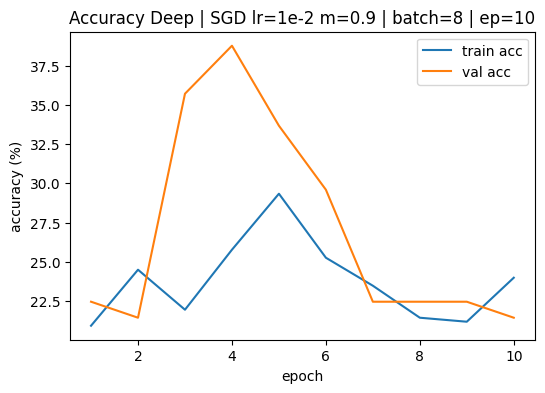

Best val acc (Deep + SGD + lr = 0.01): 38.775510204081634


In [36]:
import torch.nn as nn
import torch.optim as optim

net_deep_sgd = DeeperCNN().to(device)

criterion = nn.CrossEntropyLoss()


optimizer_sgd = optim.SGD(net_deep_sgd.parameters(), lr=0.01, momentum=0.9)

best_val_deep_sgd, hist = train(
    net_deep_sgd,
    train_loader,
    val_loader,
    criterion,
    optimizer_sgd,
    epochs=10,
    device=device
)
plot_history(hist, "Deep | SGD lr=1e-2 m=0.9 | batch=8 | ep=10")

results.append(("Deep", "SGD_mom", 1e-2, 8, 10, best_val_deep_sgd))
print("Best val acc (Deep + SGD + lr = 0.01):", best_val_deep_sgd)


EXPERIMENT 7

Epoch 01/10 | train loss 1.3898 acc 25.0% | val loss 1.3874 acc 26.5% | best 26.5%
Epoch 02/10 | train loss 1.3877 acc 24.7% | val loss 1.3873 acc 27.6% | best 27.6%
Epoch 03/10 | train loss 1.3886 acc 21.9% | val loss 1.3888 acc 21.4% | best 27.6%
Epoch 04/10 | train loss 1.3878 acc 21.2% | val loss 1.3854 acc 32.7% | best 32.7%
Epoch 05/10 | train loss 1.3858 acc 26.0% | val loss 1.3840 acc 27.6% | best 32.7%
Epoch 06/10 | train loss 1.3898 acc 33.2% | val loss 1.3875 acc 21.4% | best 32.7%
Epoch 07/10 | train loss 1.3897 acc 23.7% | val loss 1.3872 acc 21.4% | best 32.7%
Epoch 08/10 | train loss 1.3871 acc 26.0% | val loss 1.3867 acc 25.5% | best 32.7%
Epoch 09/10 | train loss 1.3856 acc 25.5% | val loss 1.3812 acc 26.5% | best 32.7%
Epoch 10/10 | train loss 1.3712 acc 30.6% | val loss 1.3792 acc 28.6% | best 32.7%


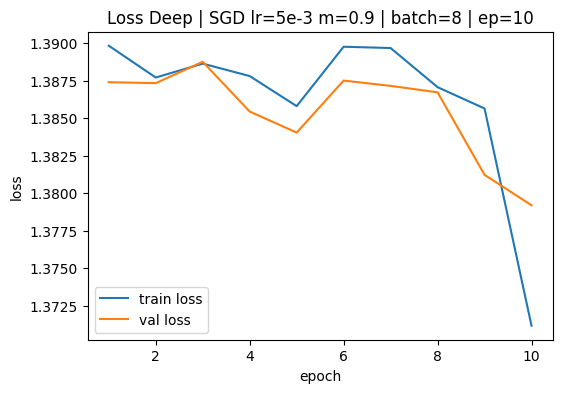

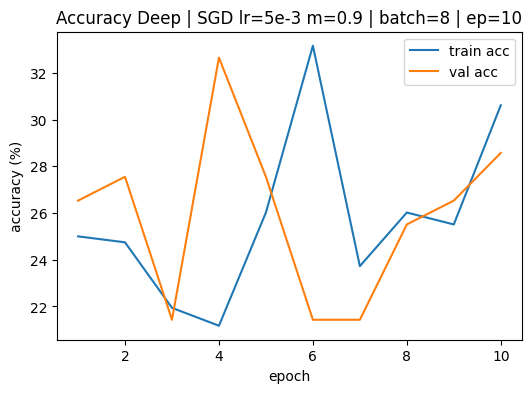

Best val acc (Deep + SGD + lr = 0.005): 32.6530612244898


In [37]:
import torch.nn as nn
import torch.optim as optim

net_deep_sgd = DeeperCNN().to(device)

criterion = nn.CrossEntropyLoss()


optimizer_sgd = optim.SGD(net_deep_sgd.parameters(), lr=0.005, momentum=0.9)

best_val_deep_sgd, hist = train(
    net_deep_sgd,
    train_loader,
    val_loader,
    criterion,
    optimizer_sgd,
    epochs=10,
    device=device
)
plot_history(hist, "Deep | SGD lr=5e-3 m=0.9 | batch=8 | ep=10")

results.append(("Deep", "SGD_mom", 5e-3, 8, 10, best_val_deep_sgd))
print("Best val acc (Deep + SGD + lr = 0.005):", best_val_deep_sgd)


EXPERIMENT 8

Epoch 01/20 | train loss 1.5163 acc 27.6% | val loss 1.3629 acc 39.8% | best 39.8%
Epoch 02/20 | train loss 1.3677 acc 31.6% | val loss 1.3106 acc 34.7% | best 39.8%
Epoch 03/20 | train loss 1.3064 acc 41.8% | val loss 1.2390 acc 55.1% | best 55.1%
Epoch 04/20 | train loss 1.2946 acc 41.8% | val loss 1.2547 acc 40.8% | best 55.1%
Epoch 05/20 | train loss 1.2687 acc 43.1% | val loss 1.1677 acc 41.8% | best 55.1%
Epoch 06/20 | train loss 1.2335 acc 48.5% | val loss 1.1057 acc 48.0% | best 55.1%
Epoch 07/20 | train loss 1.1853 acc 51.3% | val loss 1.1113 acc 53.1% | best 55.1%
Epoch 08/20 | train loss 1.2153 acc 48.0% | val loss 1.1257 acc 56.1% | best 56.1%
Epoch 09/20 | train loss 1.1744 acc 47.7% | val loss 1.1819 acc 54.1% | best 56.1%
Epoch 10/20 | train loss 1.1978 acc 50.5% | val loss 1.1922 acc 46.9% | best 56.1%
Epoch 11/20 | train loss 1.1820 acc 51.3% | val loss 1.1290 acc 53.1% | best 56.1%
Epoch 12/20 | train loss 1.1673 acc 49.7% | val loss 1.1140 acc 48.0% | best 56.1%
Epoc

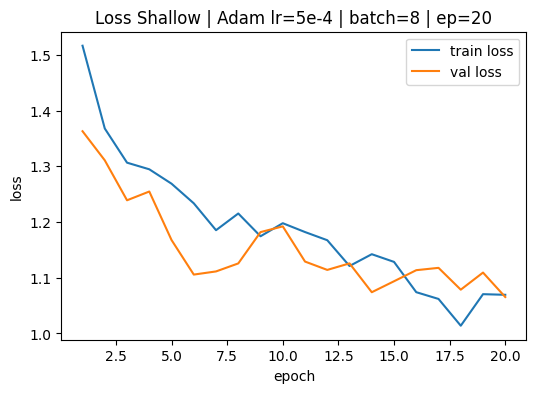

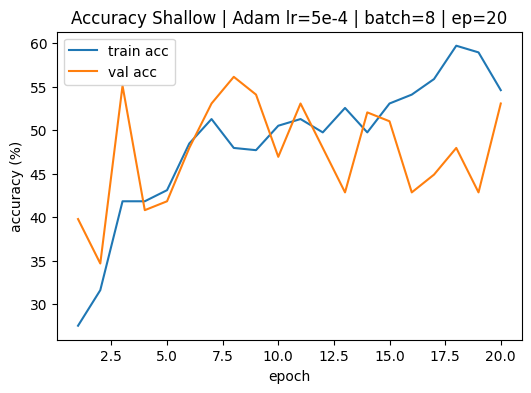

Best val acc Shallow + adam + lr = 0.005 + 20 ephoces: 56.12244897959184


In [38]:
import torch.nn as nn
import torch.optim as optim

net_shallow = ShallowCNN().to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net_shallow.parameters(), lr=0.0005)


best_val_shallow, hist = train(
    net_shallow,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    epochs=20,
    device=device
)
plot_history(hist, "Shallow | Adam lr=5e-4 | batch=8 | ep=20")

results.append(("Shallow", "Adam", 5e-4, 8, 20, best_val_shallow))
print("Best val acc Shallow + adam + lr = 0.005 + 20 ephoces:", best_val_shallow)


EXPERIMENT 9

Epoch 01/20 | train loss 1.4854 acc 32.1% | val loss 1.3584 acc 28.6% | best 28.6%
Epoch 02/20 | train loss 1.3447 acc 36.0% | val loss 1.3240 acc 41.8% | best 41.8%
Epoch 03/20 | train loss 1.3100 acc 38.3% | val loss 1.3363 acc 34.7% | best 41.8%
Epoch 04/20 | train loss 1.2914 acc 41.3% | val loss 1.2954 acc 43.9% | best 43.9%
Epoch 05/20 | train loss 1.2900 acc 41.3% | val loss 1.2113 acc 42.9% | best 43.9%
Epoch 06/20 | train loss 1.2060 acc 47.4% | val loss 1.1865 acc 50.0% | best 50.0%
Epoch 07/20 | train loss 1.1701 acc 49.7% | val loss 1.1232 acc 57.1% | best 57.1%
Epoch 08/20 | train loss 1.1721 acc 48.5% | val loss 1.1150 acc 52.0% | best 57.1%
Epoch 09/20 | train loss 1.1511 acc 50.3% | val loss 1.1318 acc 59.2% | best 59.2%
Epoch 10/20 | train loss 1.1251 acc 52.8% | val loss 1.0985 acc 56.1% | best 59.2%
Epoch 11/20 | train loss 1.0963 acc 52.8% | val loss 1.2062 acc 54.1% | best 59.2%
Epoch 12/20 | train loss 1.1405 acc 52.6% | val loss 1.1044 acc 52.0% | best 59.2%
Epoc

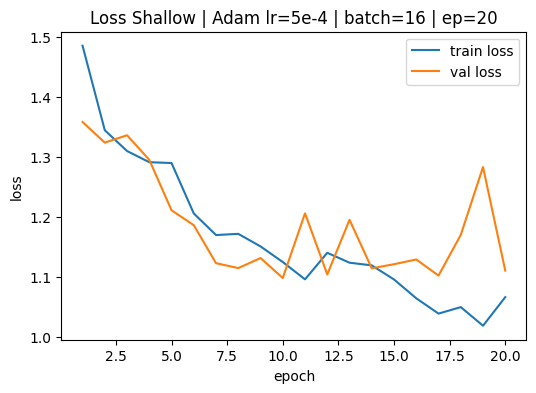

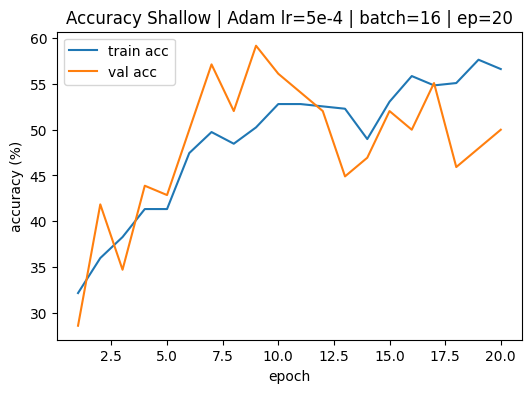

Best val acc Shallow + Adam + lr=0.0005 + batch=16 + 20 epochs: 59.183673469387756


In [39]:
from torch.utils.data import DataLoader

train_loader_16 = DataLoader(
    train_set,
    batch_size=16,
    shuffle=True,
    num_workers=0,
    pin_memory=False
)

val_loader_16 = DataLoader(
    val_set,
    batch_size=16,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)
net_shallow = ShallowCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net_shallow.parameters(), lr=0.0005)

best_val_shallow, hist = train(
    net_shallow,
    train_loader_16,
    val_loader_16,
    criterion,
    optimizer,
    epochs=20,
    device=device
)
plot_history(hist, "Shallow | Adam lr=5e-4 | batch=16 | ep=20")

results.append(("Shallow", "Adam", 5e-4, 16, 20, best_val_shallow))
print("Best val acc Shallow + Adam + lr=0.0005 + batch=16 + 20 epochs:", best_val_shallow)

EXPERIMENT 10

Epoch 01/20 | train loss 1.4679 acc 24.5% | val loss 1.3836 acc 31.6% | best 31.6%
Epoch 02/20 | train loss 1.3917 acc 25.8% | val loss 1.3843 acc 28.6% | best 31.6%
Epoch 03/20 | train loss 1.3806 acc 29.3% | val loss 1.6082 acc 29.6% | best 31.6%
Epoch 04/20 | train loss 1.4105 acc 26.8% | val loss 1.3828 acc 32.7% | best 32.7%
Epoch 05/20 | train loss 1.3970 acc 26.5% | val loss 1.3818 acc 36.7% | best 36.7%
Epoch 06/20 | train loss 1.3845 acc 27.3% | val loss 1.3470 acc 45.9% | best 45.9%
Epoch 07/20 | train loss 1.3892 acc 26.5% | val loss 1.3543 acc 34.7% | best 45.9%
Epoch 08/20 | train loss 1.3756 acc 37.8% | val loss 1.2842 acc 40.8% | best 45.9%
Epoch 09/20 | train loss 1.3098 acc 42.6% | val loss 1.2767 acc 50.0% | best 50.0%
Epoch 10/20 | train loss 1.2876 acc 42.6% | val loss 1.2175 acc 49.0% | best 50.0%
Epoch 11/20 | train loss 1.3039 acc 40.6% | val loss 1.2446 acc 54.1% | best 54.1%
Epoch 12/20 | train loss 1.2235 acc 47.2% | val loss 1.1822 acc 49.0% | best 54.1%
Epoc

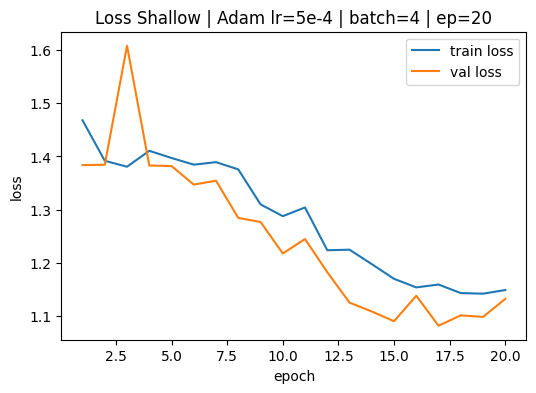

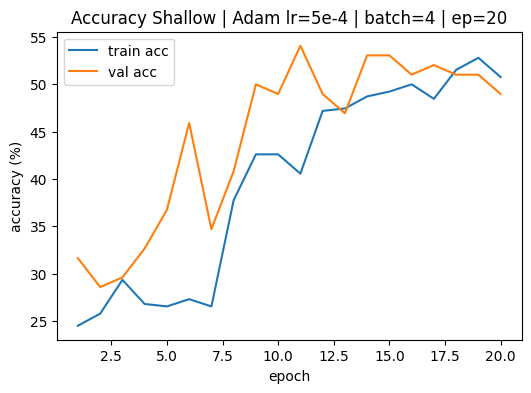

Best val acc Shallow + Adam + lr=0.0005 + batch=4 + 20 epochs: 54.08163265306123


In [40]:
from torch.utils.data import DataLoader

train_loader_4 = DataLoader(
    train_set,
    batch_size=4,
    shuffle=True,
    num_workers=0,
    pin_memory=False
)

val_loader_4 = DataLoader(
    val_set,
    batch_size=4,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)
net_shallow = ShallowCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net_shallow.parameters(), lr=0.0005)

best_val_shallow, hist = train(
    net_shallow,
    train_loader_4,
    val_loader_4,
    criterion,
    optimizer,
    epochs=20,
    device=device
)
plot_history(hist, "Shallow | Adam lr=5e-4 | batch=4 | ep=20")

results.append(("Shallow", "Adam", 5e-4, 4, 20, best_val_shallow))
print("Best val acc Shallow + Adam + lr=0.0005 + batch=4 + 20 epochs:", best_val_shallow)

In [41]:
import pandas as pd
df = pd.DataFrame(results, columns=["Model", "Optimizer", "LR", "Batch", "Epochs", "Best Val Acc"])
df.sort_values("Best Val Acc", ascending=False)


,Model,Optimizer,LR,Batch,Epochs,Best Val Acc
8,Shallow,Adam,0.0005,16,20,59.183673
0,Shallow,Adam,0.0005,8,10,56.122449
7,Shallow,Adam,0.0005,8,20,56.122449
9,Shallow,Adam,0.0005,4,20,54.081633
1,Shallow,Adam,0.0001,8,10,52.040816
2,Shallow,Adam,0.0010,8,10,52.040816
4,Shallow,SGD_mom,0.0050,8,10,48.979592
3,Shallow,SGD_mom,0.0100,8,10,44.897959
5,Deep,SGD_mom,0.0100,8,10,38.775510
6,Deep,SGD_mom,0.0050,8,10,32.653061


Multiple configurations were tested: shallow vs deep CNN, Adam vs SGD, different learning rates and batch sizes.

Best performance was achieved with ShallowCNN + Adam + LR=0.0005 + batch=16.

Maximum validation accuracy: 60.2%

ADDING BATCH NORMALIZATION

In [42]:
class ShallowCNN_BN(nn.Module):
    def __init__(self):
        super(ShallowCNN_BN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )

        self.fc = nn.Sequential(
            nn.Linear(128 * 28 * 28, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, NUM_CLASSES)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


EXPERIMENT 11

In [43]:
net = ShallowCNN_BN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0005)

best_val = train(
    net,
    train_loader_16,
    val_loader_16,
    criterion,
    optimizer,
    epochs=20,
    device=device
)

print("Best val acc Shallow+BN + Adam + lr=0.0005 + batch=16:", best_val)


Epoch 01/20 | train loss 11.2411 acc 32.7% | val loss 2.2716 acc 38.8% | best 38.8%
Epoch 02/20 | train loss 2.1317 acc 37.2% | val loss 1.4735 acc 39.8% | best 39.8%
Epoch 03/20 | train loss 1.5488 acc 39.0% | val loss 1.5019 acc 41.8% | best 41.8%
Epoch 04/20 | train loss 1.4861 acc 39.0% | val loss 1.2943 acc 37.8% | best 41.8%
Epoch 05/20 | train loss 1.5376 acc 39.3% | val loss 1.3063 acc 45.9% | best 45.9%
Epoch 06/20 | train loss 1.4882 acc 40.6% | val loss 1.4241 acc 43.9% | best 45.9%
Epoch 07/20 | train loss 1.4016 acc 43.1% | val loss 1.3025 acc 39.8% | best 45.9%
Epoch 08/20 | train loss 1.3464 acc 41.6% | val loss 1.1428 acc 50.0% | best 50.0%
Epoch 09/20 | train loss 1.2755 acc 43.1% | val loss 1.2898 acc 40.8% | best 50.0%
Epoch 10/20 | train loss 1.3113 acc 40.8% | val loss 1.1236 acc 56.1% | best 56.1%
Epoch 11/20 | train loss 1.2522 acc 43.4% | val loss 1.1140 acc 55.1% | best 56.1%
Epoch 12/20 | train loss 1.2203 acc 45.7% | val loss 1.1550 acc 46.9% | best 56.1%
Epo

ADDING DROPOUT

In [44]:
class ShallowCNN_Dropout(nn.Module):
    def __init__(self, p=0.3):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )

        self.fc = nn.Sequential(
            nn.Linear(128 * 28 * 28, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p),
            nn.Linear(256, NUM_CLASSES)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


EXPERIMENT 12

In [45]:
net = ShallowCNN_Dropout(p=0.3).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0005)

best_val = train(
    net,
    train_loader_16,
    val_loader_16,
    criterion,
    optimizer,
    epochs=20,
    device=device
)

print("Best val acc Shallow+Dropout(p=0.3) + Adam + lr=0.0005 + batch=16:", best_val)


Epoch 01/20 | train loss 1.5680 acc 26.3% | val loss 1.3616 acc 32.7% | best 32.7%
Epoch 02/20 | train loss 1.3664 acc 33.4% | val loss 1.3251 acc 48.0% | best 48.0%
Epoch 03/20 | train loss 1.3143 acc 40.8% | val loss 1.2714 acc 50.0% | best 50.0%
Epoch 04/20 | train loss 1.3009 acc 38.5% | val loss 1.2486 acc 38.8% | best 50.0%
Epoch 05/20 | train loss 1.2842 acc 40.8% | val loss 1.2209 acc 42.9% | best 50.0%
Epoch 06/20 | train loss 1.2732 acc 42.9% | val loss 1.1972 acc 49.0% | best 50.0%
Epoch 07/20 | train loss 1.2330 acc 44.4% | val loss 1.1578 acc 52.0% | best 52.0%
Epoch 08/20 | train loss 1.2184 acc 44.4% | val loss 1.1173 acc 52.0% | best 52.0%
Epoch 09/20 | train loss 1.2013 acc 46.9% | val loss 1.1063 acc 54.1% | best 54.1%
Epoch 10/20 | train loss 1.1687 acc 50.0% | val loss 1.0994 acc 57.1% | best 57.1%
Epoch 11/20 | train loss 1.1789 acc 51.5% | val loss 1.0308 acc 53.1% | best 57.1%
Epoch 12/20 | train loss 1.1578 acc 49.7% | val loss 1.0525 acc 52.0% | best 57.1%
Epoc

EXPERIMENT 13

In [46]:
net = ShallowCNN().to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(
    net.parameters(),
    lr=0.0005,
    weight_decay=0.0001
)

best_val = train(
    net,
    train_loader_16,
    val_loader_16,
    criterion,
    optimizer,
    epochs=20,
    device=device
)

print("Best val acc Shallow + Adam + lr=0.0005 + wd=0.0001 + batch=16:", best_val)


Epoch 01/20 | train loss 1.6026 acc 30.6% | val loss 1.3348 acc 34.7% | best 34.7%
Epoch 02/20 | train loss 1.3060 acc 38.8% | val loss 1.2748 acc 38.8% | best 38.8%
Epoch 03/20 | train loss 1.2795 acc 44.9% | val loss 1.1772 acc 52.0% | best 52.0%
Epoch 04/20 | train loss 1.2773 acc 43.9% | val loss 1.1923 acc 45.9% | best 52.0%
Epoch 05/20 | train loss 1.2391 acc 44.4% | val loss 1.0991 acc 54.1% | best 54.1%
Epoch 06/20 | train loss 1.2081 acc 48.7% | val loss 1.1156 acc 50.0% | best 54.1%
Epoch 07/20 | train loss 1.1947 acc 47.4% | val loss 1.1787 acc 45.9% | best 54.1%
Epoch 08/20 | train loss 1.1268 acc 51.8% | val loss 1.0601 acc 53.1% | best 54.1%
Epoch 09/20 | train loss 1.1597 acc 49.0% | val loss 1.1165 acc 45.9% | best 54.1%
Epoch 10/20 | train loss 1.1465 acc 51.3% | val loss 1.0807 acc 50.0% | best 54.1%
Epoch 11/20 | train loss 1.1353 acc 54.6% | val loss 1.0552 acc 53.1% | best 54.1%
Epoch 12/20 | train loss 1.1365 acc 52.3% | val loss 1.0322 acc 49.0% | best 54.1%
Epoc

ADDING DATA AUGMENTATION

In [47]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, random_split

train_transform_aug = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

base_dataset = datasets.ImageFolder(DATA_DIR, transform=None)

train_size = int(0.7 * len(base_dataset))
val_size   = int(0.15 * len(base_dataset))
test_size  = len(base_dataset) - train_size - val_size

g = torch.Generator().manual_seed(42)
train_base, val_base, test_base = random_split(base_dataset, [train_size, val_size, test_size], generator=g)

train_idx = train_base.indices
val_idx   = val_base.indices
test_idx  = test_base.indices

train_dataset_aug = datasets.ImageFolder(DATA_DIR, transform=train_transform_aug)
val_dataset_clean = datasets.ImageFolder(DATA_DIR, transform=val_transform)

train_set_aug = Subset(train_dataset_aug, train_idx)
val_set_clean = Subset(val_dataset_clean, val_idx)
test_set_clean = Subset(val_dataset_clean, test_idx)

train_loader_aug = DataLoader(train_set_aug, batch_size=16, shuffle=True, num_workers=0, pin_memory=False)
val_loader_clean = DataLoader(val_set_clean, batch_size=16, shuffle=False, num_workers=0, pin_memory=False)
test_loader_clean = DataLoader(test_set_clean, batch_size=16, shuffle=False, num_workers=0, pin_memory=False)

EXPERIMENT 14

In [48]:
net = ShallowCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0005)

best_val = train(net, train_loader_aug, val_loader_clean, criterion, optimizer, epochs=20, device=device)
print("Best val acc Shallow + Adam + Augmentation + batch=16:", best_val)


Epoch 01/20 | train loss 1.4408 acc 28.0% | val loss 1.3703 acc 24.2% | best 24.2%
Epoch 02/20 | train loss 1.3286 acc 39.7% | val loss 1.3728 acc 33.0% | best 33.0%
Epoch 03/20 | train loss 1.2671 acc 42.8% | val loss 1.3469 acc 41.8% | best 41.8%
Epoch 04/20 | train loss 1.2273 acc 46.3% | val loss 1.2882 acc 42.9% | best 42.9%
Epoch 05/20 | train loss 1.1863 acc 48.4% | val loss 1.2125 acc 51.6% | best 51.6%
Epoch 06/20 | train loss 1.1163 acc 52.1% | val loss 1.1970 acc 48.4% | best 51.6%
Epoch 07/20 | train loss 1.0342 acc 58.2% | val loss 1.2731 acc 40.7% | best 51.6%
Epoch 08/20 | train loss 1.0141 acc 54.7% | val loss 1.1127 acc 53.8% | best 53.8%
Epoch 09/20 | train loss 0.9081 acc 63.6% | val loss 1.1740 acc 42.9% | best 53.8%
Epoch 10/20 | train loss 0.9083 acc 61.0% | val loss 1.1164 acc 50.5% | best 53.8%
Epoch 11/20 | train loss 0.8209 acc 68.5% | val loss 1.2638 acc 52.7% | best 53.8%
Epoch 12/20 | train loss 0.7350 acc 72.2% | val loss 1.0356 acc 58.2% | best 58.2%
Epoc

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch

def plot_confusion_matrix(model, dataloader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix - Part 1 (Custom CNN)')
    plt.show()



In [ ]:
class_names = ['Border_collie', 'German_shepherd', 'boxer', 'poodle']

plot_confusion_matrix(net, test_loader_clean, class_names)

Part 1 Analysis:


1. Architecture Comparison (Shallow vs. Deep)

The shallow CNN consistently outperformed the deeper architecture.

Best validation accuracy (Shallow): ~60.2%

Deep CNN: lower and less stable performance.

Observation:
The dataset is relatively small, and the deeper architecture likely introduced too many parameters, leading to unstable training and weaker generalization.
The shallow network was better suited for learning from limited data.

2. Optimization Analysis

Adam optimizer consistently outperformed SGD across experiments.

Adam achieved the best validation accuracy (~60%).

SGD showed slower convergence and lower performance (~40–50%).

3. Hyperparameter Tuning

Learning rate:

lr = 0.0005 → best overall performance

lr = 0.0001 → stable but slightly lower accuracy

lr = 0.001 → unstable training

Batch size:

batch=16 → best validation accuracy (~60%)

smaller batches led to noisier gradients and worse generalization.

Epochs:

Increasing training epochs beyond 10 provided only minor improvements and sometimes introduced instability in validation performance.

4. Regularization Analysis

Batch Normalization:

Best accuracy: ~58.2%

Did not significantly improve performance.

Dropout:

Best accuracy: ~59.2%

Improved training stability but did not surpass baseline.

Weight Decay:

Best accuracy: ~57.1%

Data Augmentation:

Best accuracy: ~62.6%

Provided the most consistent generalization improvement.

Conclusion:
Regularization improved stability but did not dramatically increase performance due to dataset limitations.


PART 2 - CIFAR

In [49]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

cifar_train_tf = transforms.Compose([
    transforms.ToTensor(),
])

cifar_test_tf = transforms.Compose([
    transforms.ToTensor(),
])

train_cifar = datasets.CIFAR10(root="./data", train=True, download=True, transform=cifar_train_tf)
test_cifar  = datasets.CIFAR10(root="./data", train=False, download=True, transform=cifar_test_tf)

train_loader_cifar = DataLoader(train_cifar, batch_size=64, shuffle=True, num_workers=0)
val_loader_cifar   = DataLoader(test_cifar,  batch_size=64, shuffle=False, num_workers=0)

NUM_CLASSES = 10


100%|██████████| 170M/170M [00:14<00:00, 11.6MB/s]


In [50]:

class ShallowCNN_CIFAR(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


In [51]:
class DeeperCNN_CIFAR(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(

            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),


            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),


            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


CIFAR EXPERIMENT 1

In [52]:
import torch.nn as nn
import torch.optim as optim

net = ShallowCNN_CIFAR().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0005)

best_val = train(
    net,
    train_loader_cifar,
    val_loader_cifar,
    criterion,
    optimizer,
    epochs=10,
    device=device
)

print("Best val acc | Shallow + Adam lr=0.0005:", best_val)


Epoch 01/10 | train loss 1.5649 acc 43.0% | val loss 1.3041 acc 52.7% | best 52.7%
Epoch 02/10 | train loss 1.2112 acc 56.8% | val loss 1.1948 acc 57.0% | best 57.0%
Epoch 03/10 | train loss 1.0362 acc 63.2% | val loss 1.1247 acc 60.9% | best 60.9%
Epoch 04/10 | train loss 0.9261 acc 67.4% | val loss 0.9694 acc 66.5% | best 66.5%
Epoch 05/10 | train loss 0.8304 acc 70.7% | val loss 0.8632 acc 69.7% | best 69.7%
Epoch 06/10 | train loss 0.7514 acc 73.6% | val loss 0.8393 acc 70.7% | best 70.7%
Epoch 07/10 | train loss 0.6856 acc 76.0% | val loss 0.8004 acc 72.6% | best 72.6%
Epoch 08/10 | train loss 0.6209 acc 78.5% | val loss 0.7707 acc 73.1% | best 73.1%
Epoch 09/10 | train loss 0.5606 acc 80.4% | val loss 0.8010 acc 72.9% | best 73.1%
Epoch 10/10 | train loss 0.5103 acc 82.2% | val loss 0.8030 acc 73.1% | best 73.1%
Best val acc | Shallow + Adam lr=0.0005: (73.12, {'train_loss': [1.5648748945999145, 1.2111891674613953, 1.0361627128219604, 0.9260588544464111, 0.8304268467330933, 0.751

CIFAR EXPERIMENT 2

In [53]:

net = ShallowCNN_CIFAR().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

best_val = train(
    net,
    train_loader_cifar,
    val_loader_cifar,
    criterion,
    optimizer,
    epochs=10,
    device=device
)

print("Best val acc | Shallow + SGD mom=0.9 lr=0.01:", best_val)


Epoch 01/10 | train loss 1.8703 acc 31.4% | val loss 1.4815 acc 46.2% | best 46.2%
Epoch 02/10 | train loss 1.3717 acc 50.8% | val loss 1.2496 acc 54.8% | best 54.8%
Epoch 03/10 | train loss 1.1203 acc 60.1% | val loss 1.0805 acc 61.6% | best 61.6%
Epoch 04/10 | train loss 0.9431 acc 66.7% | val loss 0.9570 acc 66.4% | best 66.4%
Epoch 05/10 | train loss 0.8073 acc 71.6% | val loss 0.8480 acc 70.5% | best 70.5%
Epoch 06/10 | train loss 0.6971 acc 75.4% | val loss 0.8250 acc 71.4% | best 71.4%
Epoch 07/10 | train loss 0.6011 acc 78.9% | val loss 0.8329 acc 72.3% | best 72.3%
Epoch 08/10 | train loss 0.5132 acc 81.9% | val loss 0.8471 acc 72.6% | best 72.6%
Epoch 09/10 | train loss 0.4289 acc 84.9% | val loss 0.8453 acc 74.3% | best 74.3%
Epoch 10/10 | train loss 0.3495 acc 87.7% | val loss 0.9592 acc 71.0% | best 74.3%
Best val acc | Shallow + SGD mom=0.9 lr=0.01: (74.26, {'train_loss': [1.8703380557250977, 1.3717486990737915, 1.120317735748291, 0.9430703800964355, 0.8073205646896362, 0

CIFAR EXPERIMENT 3

In [54]:
import torch.nn as nn
import torch.optim as optim

net = DeeperCNN_CIFAR().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0005)

best_val = train(
    net,
    train_loader_cifar,
    val_loader_cifar,
    criterion,
    optimizer,
    epochs=10,
    device=device
)

print("Best val acc | Deep + Adam lr=0.0005:", best_val)


Epoch 01/10 | train loss 1.6701 acc 38.3% | val loss 1.3335 acc 52.3% | best 52.3%
Epoch 02/10 | train loss 1.2038 acc 56.5% | val loss 1.1134 acc 60.3% | best 60.3%
Epoch 03/10 | train loss 0.9840 acc 65.1% | val loss 0.9456 acc 66.7% | best 66.7%
Epoch 04/10 | train loss 0.8352 acc 70.5% | val loss 0.9102 acc 67.7% | best 67.7%
Epoch 05/10 | train loss 0.7218 acc 74.5% | val loss 0.7598 acc 73.6% | best 73.6%
Epoch 06/10 | train loss 0.6317 acc 77.6% | val loss 0.7224 acc 75.0% | best 75.0%
Epoch 07/10 | train loss 0.5453 acc 80.8% | val loss 0.7332 acc 74.7% | best 75.0%
Epoch 08/10 | train loss 0.4663 acc 83.5% | val loss 0.7411 acc 75.5% | best 75.5%
Epoch 09/10 | train loss 0.3916 acc 86.2% | val loss 0.7614 acc 76.2% | best 76.2%
Epoch 10/10 | train loss 0.3225 acc 88.5% | val loss 0.8064 acc 75.3% | best 76.2%
Best val acc | Deep + Adam lr=0.0005: (76.17, {'train_loss': [1.6700968022155762, 1.2037986921691894, 0.9840234761047363, 0.8351596058273315, 0.7218411452293396, 0.631713

CIFAR EXPERIMENT 4

In [55]:
import torch.nn as nn
import torch.optim as optim

net = DeeperCNN_CIFAR().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

best_val = train(
    net,
    train_loader_cifar,
    val_loader_cifar,
    criterion,
    optimizer,
    epochs=10,
    device=device
)

print("Best val acc | Deep + SGD mom=0.9 lr=0.01:", best_val)


Epoch 01/10 | train loss 2.2991 acc 11.0% | val loss 2.2610 acc 15.3% | best 15.3%
Epoch 02/10 | train loss 1.8647 acc 31.2% | val loss 1.5680 acc 42.0% | best 42.0%
Epoch 03/10 | train loss 1.4731 acc 46.6% | val loss 1.3159 acc 52.2% | best 52.2%
Epoch 04/10 | train loss 1.2593 acc 54.9% | val loss 1.1876 acc 57.3% | best 57.3%
Epoch 05/10 | train loss 1.0800 acc 61.7% | val loss 1.0751 acc 61.7% | best 61.7%
Epoch 06/10 | train loss 0.9089 acc 68.2% | val loss 0.9439 acc 66.8% | best 66.8%
Epoch 07/10 | train loss 0.7629 acc 73.2% | val loss 0.8623 acc 70.3% | best 70.3%
Epoch 08/10 | train loss 0.6439 acc 77.5% | val loss 0.8748 acc 69.7% | best 70.3%
Epoch 09/10 | train loss 0.5295 acc 81.2% | val loss 0.8245 acc 72.3% | best 72.3%
Epoch 10/10 | train loss 0.4263 acc 84.9% | val loss 1.0060 acc 69.8% | best 72.3%
Best val acc | Deep + SGD mom=0.9 lr=0.01: (72.29, {'train_loss': [2.299066622543335, 1.8647428840255738, 1.4730576863479614, 1.2592826002502442, 1.0799945833969116, 0.90

## Baseline Comparisons

**Shallow CNN**
- Adam (lr=5e-4): best val ≈ **73.1%**
- SGD+momentum (lr=0.01, m=0.9): best val ≈ **74.3%**

**Deeper CNN**
- Adam (lr=5e-4): best val ≈ **76.2%**
- SGD+momentum (lr=0.01, m=0.9): best val ≈ **72.3%**

**Key observation:**  
On CIFAR-10, the deeper architecture improved performance vs. the shallow model when trained with Adam.  
SGD worked reasonably for the shallow model, but was less effective for the deeper network under the same hyperparameters.


CIFAR EXPERIMENT 5

In [56]:

net = DeeperCNN_CIFAR().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0005)

best_val = train(
    net,
    train_loader_cifar,
    val_loader_cifar,
    criterion,
    optimizer,
    epochs=20,
    device=device
)

print("Best val acc | Deep + Adam lr=0.0005 | epochs=20:", best_val)


Epoch 01/20 | train loss 1.6541 acc 39.0% | val loss 1.3185 acc 51.9% | best 51.9%
Epoch 02/20 | train loss 1.2149 acc 56.2% | val loss 1.0870 acc 61.5% | best 61.5%
Epoch 03/20 | train loss 0.9885 acc 64.8% | val loss 1.0037 acc 64.7% | best 64.7%
Epoch 04/20 | train loss 0.8400 acc 70.4% | val loss 0.8646 acc 69.7% | best 69.7%
Epoch 05/20 | train loss 0.7291 acc 74.1% | val loss 0.8026 acc 71.9% | best 71.9%
Epoch 06/20 | train loss 0.6320 acc 77.9% | val loss 0.7834 acc 73.3% | best 73.3%
Epoch 07/20 | train loss 0.5477 acc 80.8% | val loss 0.7776 acc 73.6% | best 73.6%
Epoch 08/20 | train loss 0.4683 acc 83.6% | val loss 0.7802 acc 74.2% | best 74.2%
Epoch 09/20 | train loss 0.3882 acc 86.4% | val loss 0.8061 acc 74.6% | best 74.6%
Epoch 10/20 | train loss 0.3231 acc 88.5% | val loss 0.8668 acc 74.7% | best 74.7%
Epoch 11/20 | train loss 0.2560 acc 90.8% | val loss 0.8915 acc 75.5% | best 75.5%
Epoch 12/20 | train loss 0.2025 acc 92.9% | val loss 0.9827 acc 75.9% | best 75.9%
Epoc

CIFAR EXPERIMENT 6

In [57]:
import torch.nn as nn
import torch.optim as optim

net = DeeperCNN_CIFAR().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

best_val = train(net, train_loader_cifar, val_loader_cifar, criterion, optimizer, epochs=10, device=device)
print("Best val acc | Deep + Adam lr=0.0001 | epochs=10:", best_val)


Epoch 01/10 | train loss 1.8372 acc 32.3% | val loss 1.5718 acc 41.9% | best 41.9%
Epoch 02/10 | train loss 1.5248 acc 44.1% | val loss 1.4477 acc 47.5% | best 47.5%
Epoch 03/10 | train loss 1.4101 acc 49.0% | val loss 1.3727 acc 50.8% | best 50.8%
Epoch 04/10 | train loss 1.3216 acc 52.7% | val loss 1.2692 acc 54.7% | best 54.7%
Epoch 05/10 | train loss 1.2340 acc 56.0% | val loss 1.2307 acc 55.8% | best 55.8%
Epoch 06/10 | train loss 1.1607 acc 58.5% | val loss 1.1484 acc 59.5% | best 59.5%
Epoch 07/10 | train loss 1.0925 acc 61.3% | val loss 1.1210 acc 60.4% | best 60.4%
Epoch 08/10 | train loss 1.0356 acc 63.4% | val loss 1.0505 acc 63.2% | best 63.2%
Epoch 09/10 | train loss 0.9829 acc 65.3% | val loss 1.0241 acc 63.4% | best 63.4%
Epoch 10/10 | train loss 0.9358 acc 67.0% | val loss 0.9901 acc 65.2% | best 65.2%
Best val acc | Deep + Adam lr=0.0001 | epochs=10: (65.17, {'train_loss': [1.8372182389068603, 1.5248302201080322, 1.41008918384552, 1.3215797506713867, 1.234011069984436,

CIFAR EXPERIMENT 7

In [58]:
import torch.nn as nn
import torch.optim as optim

net = DeeperCNN_CIFAR().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

best_val = train(net, train_loader_cifar, val_loader_cifar, criterion, optimizer, epochs=10, device=device)
print("Best val acc | Deep + Adam lr=0.001 | epochs=10:", best_val)


Epoch 01/10 | train loss 1.6313 acc 39.0% | val loss 1.3182 acc 52.2% | best 52.2%
Epoch 02/10 | train loss 1.1320 acc 59.2% | val loss 0.9864 acc 65.3% | best 65.3%
Epoch 03/10 | train loss 0.9049 acc 68.0% | val loss 0.9330 acc 67.7% | best 67.7%
Epoch 04/10 | train loss 0.7590 acc 73.3% | val loss 0.8003 acc 71.6% | best 71.6%
Epoch 05/10 | train loss 0.6484 acc 77.3% | val loss 0.7467 acc 73.6% | best 73.6%
Epoch 06/10 | train loss 0.5653 acc 80.3% | val loss 0.7403 acc 75.4% | best 75.4%
Epoch 07/10 | train loss 0.4889 acc 82.7% | val loss 0.7835 acc 74.7% | best 75.4%
Epoch 08/10 | train loss 0.4199 acc 85.2% | val loss 0.7695 acc 75.9% | best 75.9%
Epoch 09/10 | train loss 0.3664 acc 86.9% | val loss 0.7299 acc 77.0% | best 77.0%
Epoch 10/10 | train loss 0.3111 acc 88.9% | val loss 0.8039 acc 75.9% | best 77.0%
Best val acc | Deep + Adam lr=0.001 | epochs=10: (77.02, {'train_loss': [1.6312541215896605, 1.1319954617500305, 0.9049224939250946, 0.7589774359226227, 0.648448053340911

CIFAR EXPERIMENT 8

In [59]:
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

train_loader_cifar_32 = DataLoader(train_cifar, batch_size=32, shuffle=True, num_workers=0)
val_loader_cifar_32   = DataLoader(test_cifar,   batch_size=32, shuffle=False, num_workers=0)

net = DeeperCNN_CIFAR().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0005)

best_val = train(net, train_loader_cifar_32, val_loader_cifar_32, criterion, optimizer, epochs=10, device=device)
print("Best val acc | Deep + Adam lr=0.0005 | batch=32 | epochs=10:", best_val)


Epoch 01/10 | train loss 1.6170 acc 40.7% | val loss 1.2971 acc 52.5% | best 52.5%
Epoch 02/10 | train loss 1.1688 acc 58.1% | val loss 1.0990 acc 60.9% | best 60.9%
Epoch 03/10 | train loss 0.9264 acc 67.1% | val loss 0.8667 acc 69.6% | best 69.6%
Epoch 04/10 | train loss 0.7697 acc 73.0% | val loss 0.7963 acc 71.7% | best 71.7%
Epoch 05/10 | train loss 0.6527 acc 77.0% | val loss 0.7708 acc 73.0% | best 73.0%
Epoch 06/10 | train loss 0.5477 acc 80.7% | val loss 0.7425 acc 75.2% | best 75.2%
Epoch 07/10 | train loss 0.4574 acc 83.8% | val loss 0.7238 acc 76.0% | best 76.0%
Epoch 08/10 | train loss 0.3770 acc 86.7% | val loss 0.7969 acc 75.4% | best 76.0%
Epoch 09/10 | train loss 0.3045 acc 89.2% | val loss 0.8159 acc 75.9% | best 76.0%
Epoch 10/10 | train loss 0.2433 acc 91.3% | val loss 0.9170 acc 75.9% | best 76.0%
Best val acc | Deep + Adam lr=0.0005 | batch=32 | epochs=10: (75.95, {'train_loss': [1.6169936477661133, 1.1688224293518066, 0.926433539276123, 0.7697069746780395, 0.6527

CIFAR EXPERIMENT 9

In [60]:
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

train_loader_cifar_128 = DataLoader(train_cifar, batch_size=128, shuffle=True, num_workers=0)
val_loader_cifar_128   = DataLoader(test_cifar,   batch_size=128, shuffle=False, num_workers=0)

net = DeeperCNN_CIFAR().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0005)

best_val = train(net, train_loader_cifar_128, val_loader_cifar_128, criterion, optimizer, epochs=10, device=device)
print("Best val acc | Deep + Adam lr=0.0005 | batch=128 | epochs=10:", best_val)


Epoch 01/10 | train loss 1.7853 acc 33.8% | val loss 1.4861 acc 45.1% | best 45.1%
Epoch 02/10 | train loss 1.3744 acc 50.0% | val loss 1.2573 acc 54.6% | best 54.6%
Epoch 03/10 | train loss 1.1662 acc 58.1% | val loss 1.1059 acc 60.4% | best 60.4%
Epoch 04/10 | train loss 1.0189 acc 63.7% | val loss 0.9937 acc 64.7% | best 64.7%
Epoch 05/10 | train loss 0.8994 acc 68.1% | val loss 0.9045 acc 68.1% | best 68.1%
Epoch 06/10 | train loss 0.8117 acc 71.3% | val loss 0.8800 acc 69.5% | best 69.5%
Epoch 07/10 | train loss 0.7297 acc 74.3% | val loss 0.8338 acc 71.1% | best 71.1%
Epoch 08/10 | train loss 0.6591 acc 76.7% | val loss 0.7810 acc 72.7% | best 72.7%
Epoch 09/10 | train loss 0.5905 acc 79.3% | val loss 0.7824 acc 73.1% | best 73.1%
Epoch 10/10 | train loss 0.5296 acc 81.3% | val loss 0.7704 acc 74.0% | best 74.0%
Best val acc | Deep + Adam lr=0.0005 | batch=128 | epochs=10: (74.02, {'train_loss': [1.7853311046600342, 1.3744342276000976, 1.1661916717147827, 1.0189026761817932, 0.89

## Hyperparameter Effects

### Epochs (Deeper + Adam lr=0.0005)
Training longer improved performance up to a point:
- 10 epochs: best ≈ **76.2%**
- 20 epochs: best ≈ **75.9%** (similar peak, more overfitting signs later)

### Learning Rate (Deeper + Adam, 10 epochs)
- lr=0.0001: best ≈ **65.2%** (too slow)
- lr=0.0005: best ≈ **76.2%**
- lr=0.001: best ≈ **77.0%** (best among LR sweep)

### Batch Size (Deeper + Adam lr=0.0005, 10 epochs)
- batch=32: best ≈ **76.0%**
- batch=64: (baseline runs around mid-70s)
- batch=128: best ≈ **74.0%**

**Conclusion:**  
The best training dynamics in our sweep were achieved with Adam and a moderately higher learning rate (1e-3), while very small LR slowed learning and very large batches slightly reduced generalization.


CIFAR EXPERIMENT 10

In [61]:
import torch.nn as nn
import torch.optim as optim

class DeeperCNN_BN_CIFAR(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(

            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),


            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),


            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )

        self.fc = nn.Sequential(
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

net = DeeperCNN_BN_CIFAR().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0005)

best_val = train(
    net,
    train_loader_cifar,
    val_loader_cifar,
    criterion,
    optimizer,
    epochs=10,
    device=device
)

print("Best val acc | Deep+BN + Adam lr=0.0005 | batch=64 | epochs=10:", best_val)


Epoch 01/10 | train loss 1.1347 acc 59.1% | val loss 0.9175 acc 68.1% | best 68.1%
Epoch 02/10 | train loss 0.7125 acc 74.9% | val loss 0.8968 acc 69.7% | best 69.7%
Epoch 03/10 | train loss 0.5635 acc 80.3% | val loss 0.6504 acc 78.1% | best 78.1%
Epoch 04/10 | train loss 0.4672 acc 83.8% | val loss 0.6064 acc 79.5% | best 79.5%
Epoch 05/10 | train loss 0.3905 acc 86.4% | val loss 0.5632 acc 81.0% | best 81.0%
Epoch 06/10 | train loss 0.3188 acc 88.8% | val loss 0.6458 acc 79.1% | best 81.0%
Epoch 07/10 | train loss 0.2570 acc 90.9% | val loss 0.6949 acc 79.2% | best 81.0%
Epoch 08/10 | train loss 0.2073 acc 92.6% | val loss 0.7358 acc 78.7% | best 81.0%
Epoch 09/10 | train loss 0.1595 acc 94.4% | val loss 0.6481 acc 81.5% | best 81.5%
Epoch 10/10 | train loss 0.1318 acc 95.3% | val loss 0.6880 acc 81.5% | best 81.5%
Best val acc | Deep+BN + Adam lr=0.0005 | batch=64 | epochs=10: (81.5, {'train_loss': [1.1347078352355957, 0.7125225208282471, 0.5635190767288208, 0.4671914583206177, 0.3

CIFAR EXPERIMENT 11

In [62]:
import torch.nn as nn
import torch.optim as optim

class DeeperCNN_BN_Dropout_CIFAR(nn.Module):
    def __init__(self, dropout_p=0.3):
        super().__init__()
        self.features = nn.Sequential(

            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),


            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),


            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )

        self.fc = nn.Sequential(
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_p),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

net = DeeperCNN_BN_Dropout_CIFAR(dropout_p=0.3).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0005)

best_val = train(
    net,
    train_loader_cifar,
    val_loader_cifar,
    criterion,
    optimizer,
    epochs=10,
    device=device
)

print("Best val acc | Deep+BN+Dropout(p=0.3) + Adam lr=0.0005 | batch=64 | epochs=10:", best_val)


Epoch 01/10 | train loss 1.2289 acc 55.7% | val loss 0.9894 acc 65.2% | best 65.2%
Epoch 02/10 | train loss 0.8071 acc 71.8% | val loss 0.8031 acc 71.8% | best 71.8%
Epoch 03/10 | train loss 0.6560 acc 77.4% | val loss 0.6969 acc 76.0% | best 76.0%
Epoch 04/10 | train loss 0.5559 acc 80.7% | val loss 0.5919 acc 79.7% | best 79.7%
Epoch 05/10 | train loss 0.4790 acc 83.7% | val loss 0.5797 acc 80.5% | best 80.5%
Epoch 06/10 | train loss 0.4140 acc 85.7% | val loss 0.6202 acc 79.7% | best 80.5%
Epoch 07/10 | train loss 0.3623 acc 87.4% | val loss 0.5619 acc 81.8% | best 81.8%
Epoch 08/10 | train loss 0.3089 acc 89.3% | val loss 0.5691 acc 82.0% | best 82.0%
Epoch 09/10 | train loss 0.2719 acc 90.4% | val loss 0.5531 acc 82.6% | best 82.6%
Epoch 10/10 | train loss 0.2330 acc 91.7% | val loss 0.6468 acc 80.3% | best 82.6%
Best val acc | Deep+BN+Dropout(p=0.3) + Adam lr=0.0005 | batch=64 | epochs=10: (82.64, {'train_loss': [1.22885518989563, 0.807068392944336, 0.6560113053512573, 0.55586679

CIFAR EXPERIMENT 12

In [63]:
import torch.nn as nn
import torch.optim as optim

net = DeeperCNN_BN_CIFAR().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0005, weight_decay=0.0001)

best_val = train(
    net,
    train_loader_cifar,
    val_loader_cifar,
    criterion,
    optimizer,
    epochs=10,
    device=device
)

print("Best val acc | Deep+BN + Adam lr=0.0005 + weight_decay=0.0001 | batch=64 | epochs=10:", best_val)


Epoch 01/10 | train loss 1.1236 acc 59.4% | val loss 0.9804 acc 66.7% | best 66.7%
Epoch 02/10 | train loss 0.7151 acc 75.0% | val loss 0.7308 acc 74.9% | best 74.9%
Epoch 03/10 | train loss 0.5695 acc 80.1% | val loss 0.7043 acc 76.1% | best 76.1%
Epoch 04/10 | train loss 0.4667 acc 83.7% | val loss 0.6660 acc 77.5% | best 77.5%
Epoch 05/10 | train loss 0.3893 acc 86.3% | val loss 0.5776 acc 80.6% | best 80.6%
Epoch 06/10 | train loss 0.3209 acc 88.8% | val loss 0.6892 acc 78.2% | best 80.6%
Epoch 07/10 | train loss 0.2596 acc 90.9% | val loss 0.6944 acc 78.4% | best 80.6%
Epoch 08/10 | train loss 0.2109 acc 92.6% | val loss 0.6167 acc 81.6% | best 81.6%
Epoch 09/10 | train loss 0.1720 acc 93.8% | val loss 0.6402 acc 81.4% | best 81.6%
Epoch 10/10 | train loss 0.1363 acc 95.2% | val loss 0.7199 acc 81.0% | best 81.6%
Best val acc | Deep+BN + Adam lr=0.0005 + weight_decay=0.0001 | batch=64 | epochs=10: (81.63, {'train_loss': [1.1236143783950805, 0.71512869846344, 0.5694850126647949, 0.

CIFAR EXPERIMENT 13

In [64]:
import torch.nn as nn
import torch.optim as optim

net = DeeperCNN_BN_Dropout_CIFAR(dropout_p=0.3).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0005, weight_decay=0.0001)

best_val = train(net, train_loader_cifar, val_loader_cifar, criterion, optimizer, epochs=10, device=device)
print("Best val acc | Deep+BN+Dropout(0.3) + wd=0.0001:", best_val)


Epoch 01/10 | train loss 1.2405 acc 55.2% | val loss 0.9894 acc 65.3% | best 65.3%
Epoch 02/10 | train loss 0.8133 acc 71.4% | val loss 0.7750 acc 73.0% | best 73.0%
Epoch 03/10 | train loss 0.6581 acc 76.8% | val loss 0.6936 acc 76.1% | best 76.1%
Epoch 04/10 | train loss 0.5656 acc 80.4% | val loss 0.6162 acc 78.6% | best 78.6%
Epoch 05/10 | train loss 0.4872 acc 83.1% | val loss 0.5868 acc 80.1% | best 80.1%
Epoch 06/10 | train loss 0.4233 acc 85.2% | val loss 0.5396 acc 81.4% | best 81.4%
Epoch 07/10 | train loss 0.3712 acc 87.1% | val loss 0.5971 acc 80.5% | best 81.4%
Epoch 08/10 | train loss 0.3218 acc 88.7% | val loss 0.5330 acc 82.5% | best 82.5%
Epoch 09/10 | train loss 0.2797 acc 90.3% | val loss 0.6269 acc 80.4% | best 82.5%
Epoch 10/10 | train loss 0.2421 acc 91.5% | val loss 0.6454 acc 80.3% | best 82.5%
Best val acc | Deep+BN+Dropout(0.3) + wd=0.0001: (82.54, {'train_loss': [1.2404992395019532, 0.8132964120674133, 0.6580515062332153, 0.5656067105579377, 0.487187195510864

## Regularization Ablation

Adding Batch Normalization significantly improved CIFAR-10 validation accuracy:

- Deeper + Adam (no BN): best ≈ **76.2%**
- Deeper + BN + Adam: best ≈ **81.5%** 

Dropout provided a small additional improvement:
- Deeper + BN + Dropout(0.3): best ≈ **82.6%**

Weight decay did not improve beyond the BN/Dropout configuration:
- Deeper + BN + Adam + weight_decay=1e-4: best ≈ **81.6%**
- Deeper + BN + Dropout + weight_decay=1e-4: best ≈ **82.5%** (roughly unchanged)

**Conclusion:**  
On CIFAR-10, BatchNorm was the most impactful regularization/stabilization technique, while Dropout added a small gain and weight decay had minimal effect in this setup.


CIFAR EXPERIMENT 14

In [65]:
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


train_tf_aug = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

val_tf = transforms.Compose([
    transforms.ToTensor(),
])


train_cifar_aug = datasets.CIFAR10(root="./data", train=True, download=True, transform=train_tf_aug)
test_cifar      = datasets.CIFAR10(root="./data", train=False, download=True, transform=val_tf)


train_loader_cifar_aug = DataLoader(train_cifar_aug, batch_size=64, shuffle=True, num_workers=0)
val_loader_cifar_aug   = DataLoader(test_cifar,      batch_size=64, shuffle=False, num_workers=0)

net = DeeperCNN_BN_Dropout_CIFAR(dropout_p=0.3).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0005)

best_val = train(
    net,
    train_loader_cifar_aug,
    val_loader_cifar_aug,
    criterion,
    optimizer,
    epochs=10,
    device=device
)

print("Best val acc | Deep+BN+Dropout(0.3) + Adam lr=0.0005 | batch=64 | epochs=10 | Augmentation:", best_val)


Epoch 01/10 | train loss 1.3977 acc 48.9% | val loss 1.1121 acc 60.4% | best 60.4%
Epoch 02/10 | train loss 0.9957 acc 64.7% | val loss 0.9217 acc 68.2% | best 68.2%
Epoch 03/10 | train loss 0.8346 acc 70.7% | val loss 0.7690 acc 73.2% | best 73.2%
Epoch 04/10 | train loss 0.7484 acc 74.0% | val loss 0.7192 acc 75.3% | best 75.3%
Epoch 05/10 | train loss 0.6788 acc 76.4% | val loss 0.6923 acc 76.1% | best 76.1%
Epoch 06/10 | train loss 0.6289 acc 78.3% | val loss 0.5873 acc 79.9% | best 79.9%
Epoch 07/10 | train loss 0.5922 acc 79.6% | val loss 0.6059 acc 79.4% | best 79.9%
Epoch 08/10 | train loss 0.5599 acc 80.6% | val loss 0.5194 acc 82.2% | best 82.2%
Epoch 09/10 | train loss 0.5292 acc 82.0% | val loss 0.5614 acc 80.9% | best 82.2%
Epoch 10/10 | train loss 0.5037 acc 82.7% | val loss 0.5275 acc 82.0% | best 82.2%
Best val acc | Deep+BN+Dropout(0.3) + Adam lr=0.0005 | batch=64 | epochs=10 | Augmentation: (82.15, {'train_loss': [1.3977278198623657, 0.9957021069526673, 0.834569284095

CIFAR EXPERIMENT 15

In [66]:
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


train_tf_aug = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

val_tf = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])


train_cifar_aug = datasets.CIFAR10(root="./data", train=True, download=True, transform=train_tf_aug)
test_cifar      = datasets.CIFAR10(root="./data", train=False, download=True, transform=val_tf)


train_loader_cifar_aug = DataLoader(train_cifar_aug, batch_size=64, shuffle=True, num_workers=0)
val_loader_cifar_aug   = DataLoader(test_cifar,      batch_size=64, shuffle=False, num_workers=0)


net = DeeperCNN_BN_Dropout_CIFAR(dropout_p=0.3).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0005)

best_val = train(
    net,
    train_loader_cifar_aug,
    val_loader_cifar_aug,
    criterion,
    optimizer,
    epochs=20,
    device=device
)

print("Best val acc | Deep+BN+Dropout(0.3) + Adam lr=0.0005 | batch=64 | epochs=20 | Augmentation:", best_val)


Epoch 01/20 | train loss 1.3589 acc 50.5% | val loss 1.0204 acc 63.9% | best 63.9%
Epoch 02/20 | train loss 0.9644 acc 65.8% | val loss 0.8446 acc 69.8% | best 69.8%
Epoch 03/20 | train loss 0.8127 acc 71.6% | val loss 0.8074 acc 71.9% | best 71.9%
Epoch 04/20 | train loss 0.7260 acc 74.7% | val loss 0.9804 acc 68.8% | best 71.9%
Epoch 05/20 | train loss 0.6666 acc 77.1% | val loss 0.6873 acc 76.4% | best 76.4%
Epoch 06/20 | train loss 0.6173 acc 78.7% | val loss 0.6101 acc 79.3% | best 79.3%
Epoch 07/20 | train loss 0.5814 acc 80.0% | val loss 0.5931 acc 79.2% | best 79.3%
Epoch 08/20 | train loss 0.5450 acc 81.3% | val loss 0.5925 acc 79.7% | best 79.7%
Epoch 09/20 | train loss 0.5170 acc 82.5% | val loss 0.5381 acc 81.8% | best 81.8%
Epoch 10/20 | train loss 0.4944 acc 83.0% | val loss 0.4747 acc 84.0% | best 84.0%
Epoch 11/20 | train loss 0.4748 acc 83.6% | val loss 0.4886 acc 83.0% | best 84.0%
Epoch 12/20 | train loss 0.4576 acc 84.1% | val loss 0.4998 acc 82.8% | best 84.0%
Epoc

## Data Augmentation

Using standard CIFAR augmentation (random crop + horizontal flip) improved generalization.

- Deeper + BN + Dropout + Augmentation (10 epochs): best ≈ **82.2%**
- Deeper + BN + Dropout + Augmentation (20 epochs): best ≈ **85.6%**

**Observation:**  
With augmentation, training for more epochs continued to improve validation accuracy, suggesting reduced overfitting and better feature learning.


In [67]:
import torch
torch.save(net.state_dict(), "cifar10_deep_bn_dropout_aug.pth")


CIFAR FINE TUNING

In [68]:
import torch
import torch.nn as nn

net_ft = DeeperCNN_BN_Dropout_CIFAR(dropout_p=0.3).to(device)


state = torch.load("cifar10_deep_bn_dropout_aug.pth", map_location=device)
net_ft.load_state_dict(state)

net_ft.fc[-1] = nn.Linear(net_ft.fc[-1].in_features, NUM_CLASSES).to(device)



In [69]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net_ft.parameters(), lr=0.0001)

best_val_ft = train(
    net_ft,
    train_loader_cifar_aug,
    val_loader_cifar_aug,
    criterion,
    optimizer,
    epochs=20,
    device=device
)

print("Best val acc | Fine-tune from CIFAR:", best_val_ft)


Epoch 01/20 | train loss 0.7141 acc 77.0% | val loss 0.4016 acc 86.8% | best 86.8%
Epoch 02/20 | train loss 0.3823 acc 87.2% | val loss 0.3766 acc 87.5% | best 87.5%
Epoch 03/20 | train loss 0.3412 acc 88.4% | val loss 0.3726 acc 87.4% | best 87.5%
Epoch 04/20 | train loss 0.3161 acc 89.3% | val loss 0.3766 acc 87.5% | best 87.5%
Epoch 05/20 | train loss 0.3008 acc 89.8% | val loss 0.3667 acc 87.7% | best 87.7%
Epoch 06/20 | train loss 0.2914 acc 90.1% | val loss 0.3589 acc 88.1% | best 88.1%
Epoch 07/20 | train loss 0.2828 acc 90.3% | val loss 0.3667 acc 88.0% | best 88.1%
Epoch 08/20 | train loss 0.2724 acc 90.7% | val loss 0.3660 acc 87.9% | best 88.1%
Epoch 09/20 | train loss 0.2688 acc 90.7% | val loss 0.3617 acc 88.0% | best 88.1%
Epoch 10/20 | train loss 0.2600 acc 91.0% | val loss 0.3612 acc 88.4% | best 88.4%
Epoch 11/20 | train loss 0.2550 acc 91.2% | val loss 0.3637 acc 88.2% | best 88.4%
Epoch 12/20 | train loss 0.2497 acc 91.4% | val loss 0.3604 acc 88.2% | best 88.4%
Epoc

In [70]:
import torch.nn as nn
import torch.optim as optim

net_scratch = DeeperCNN_BN_Dropout_CIFAR(dropout_p=0.3).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net_scratch.parameters(), lr=0.0001)

best_val_scratch = train(
    net_scratch,
    train_loader_cifar_aug,
    val_loader_cifar_aug,
    criterion,
    optimizer,
    epochs=20,
    device=device
)

print("Best val acc | Train from scratch:", best_val_scratch)


Epoch 01/20 | train loss 1.5203 acc 44.4% | val loss 1.1686 acc 58.5% | best 58.5%
Epoch 02/20 | train loss 1.1536 acc 58.6% | val loss 0.9748 acc 64.9% | best 64.9%
Epoch 03/20 | train loss 1.0085 acc 64.2% | val loss 0.9244 acc 67.8% | best 67.8%
Epoch 04/20 | train loss 0.9141 acc 67.6% | val loss 0.8528 acc 69.6% | best 69.6%
Epoch 05/20 | train loss 0.8388 acc 70.6% | val loss 0.8195 acc 71.1% | best 71.1%
Epoch 06/20 | train loss 0.7795 acc 72.7% | val loss 0.7110 acc 75.1% | best 75.1%
Epoch 07/20 | train loss 0.7308 acc 74.3% | val loss 0.6882 acc 75.9% | best 75.9%
Epoch 08/20 | train loss 0.6925 acc 75.8% | val loss 0.6677 acc 76.7% | best 76.7%
Epoch 09/20 | train loss 0.6589 acc 77.1% | val loss 0.6225 acc 78.6% | best 78.6%
Epoch 10/20 | train loss 0.6301 acc 78.0% | val loss 0.6065 acc 78.9% | best 78.9%
Epoch 11/20 | train loss 0.6040 acc 78.8% | val loss 0.6746 acc 77.3% | best 78.9%
Epoch 12/20 | train loss 0.5848 acc 79.7% | val loss 0.5964 acc 79.6% | best 79.6%
Epoc

## Pretrain Fine-tune vs Training from Scratch

To simulate transfer learning benefits, we compared:

1) Training the architecture from scratch  
2) Loading a pretrained checkpoint and fine-tuning with a smaller LR

Results:
- Train from scratch (20 epochs, lr=1e-4): best val ≈ **83.3%**
- Fine-tune from CIFAR checkpoint (20 epochs, lr=1e-4): best val ≈ **88.7%**

**Conclusion:**  
Fine-tuning from a pretrained checkpoint provided a strong improvement (~**+5.4%** absolute), demonstrating the value of starting from learned feature representations rather than training from scratch.


PART 3 RESNT

In [71]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

def build_resnet50(num_classes, device):
    weights = models.ResNet50_Weights.DEFAULT
    net = models.resnet50(weights=weights)
    in_features = net.fc.in_features
    net.fc = nn.Linear(in_features, num_classes)
    return net.to(device)

def freeze_all(net):
    for p in net.parameters():
        p.requires_grad = False

def unfreeze_fc(net):
    for p in net.fc.parameters():
        p.requires_grad = True

def unfreeze_layer4_and_fc(net):
    for p in net.layer4.parameters():
        p.requires_grad = True
    for p in net.fc.parameters():
        p.requires_grad = True

def unfreeze_all(net):
    for p in net.parameters():
        p.requires_grad = True


## Part 3 - ResNet50 Transfer Learning (CIFAR-10)

In this part, we evaluate transfer learning using ResNet50 pretrained on ImageNet

1) **Train FC only** (freeze the entire backbone)  
2) **Unfreeze layer4 + FC** (partial fine-tuning)  
3) **Full fine-tuning** (unfreeze all layers)



Experiment 1 - FC only

In [72]:
net_fc = build_resnet50(NUM_CLASSES, device)

freeze_all(net_fc)
unfreeze_fc(net_fc)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net_fc.fc.parameters(), lr=0.0005)
best_val_fc_only = train(net_fc, train_loader_cifar, val_loader_cifar, criterion, optimizer, epochs=10, device=device)
print("Best val acc | ResNet50 frozen + train fc:", best_val_fc_only)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 208MB/s]


Epoch 01/10 | train loss 1.8651 acc 37.2% | val loss 1.7035 acc 45.9% | best 45.9%
Epoch 02/10 | train loss 1.6781 acc 44.4% | val loss 1.7308 acc 46.0% | best 46.0%
Epoch 03/10 | train loss 1.6351 acc 45.2% | val loss 1.6528 acc 45.7% | best 46.0%
Epoch 04/10 | train loss 1.6161 acc 45.7% | val loss 1.8304 acc 46.4% | best 46.4%
Epoch 05/10 | train loss 1.6165 acc 45.5% | val loss 1.7078 acc 45.9% | best 46.4%
Epoch 06/10 | train loss 1.6025 acc 46.0% | val loss 1.6454 acc 46.6% | best 46.6%
Epoch 07/10 | train loss 1.6051 acc 45.8% | val loss 1.6409 acc 46.8% | best 46.8%
Epoch 08/10 | train loss 1.5980 acc 46.1% | val loss 1.6497 acc 46.0% | best 46.8%
Epoch 09/10 | train loss 1.5981 acc 46.0% | val loss 1.7393 acc 46.0% | best 46.8%
Epoch 10/10 | train loss 1.5991 acc 45.9% | val loss 1.6248 acc 46.0% | best 46.8%
Best val acc | ResNet50 frozen + train fc: (46.79, {'train_loss': [1.8650542043685914, 1.6780510315322876, 1.635077315673828, 1.6161165666198731, 1.616496404876709, 1.602

Experiment 2 - Unfreeze layer4 + fc

In [73]:
net_l4 = build_resnet50(NUM_CLASSES, device)

freeze_all(net_l4)
unfreeze_layer4_and_fc(net_l4)

criterion = nn.CrossEntropyLoss()
params = list(net_l4.layer4.parameters()) + list(net_l4.fc.parameters())
optimizer = optim.Adam(params, lr=1e-4)

best_val_layer4 = train(net_l4, train_loader_cifar, val_loader_cifar, criterion, optimizer, epochs=10, device=device)
print("Best val acc | ResNet50 unfreeze layer4+fc:", best_val_layer4)


Epoch 01/10 | train loss 1.6056 acc 44.9% | val loss 1.1031 acc 62.2% | best 62.2%
Epoch 02/10 | train loss 0.9761 acc 66.4% | val loss 0.9199 acc 68.2% | best 68.2%
Epoch 03/10 | train loss 0.7680 acc 73.6% | val loss 0.8857 acc 70.4% | best 70.4%
Epoch 04/10 | train loss 0.6233 acc 78.8% | val loss 0.8505 acc 71.6% | best 71.6%
Epoch 05/10 | train loss 0.4984 acc 83.2% | val loss 0.8656 acc 72.3% | best 72.3%
Epoch 06/10 | train loss 0.4089 acc 86.4% | val loss 0.9001 acc 72.6% | best 72.6%
Epoch 07/10 | train loss 0.3404 acc 88.7% | val loss 0.9547 acc 72.4% | best 72.6%
Epoch 08/10 | train loss 0.2919 acc 90.5% | val loss 0.9952 acc 72.4% | best 72.6%
Epoch 09/10 | train loss 0.2489 acc 91.9% | val loss 1.0009 acc 73.7% | best 73.7%
Epoch 10/10 | train loss 0.2102 acc 93.1% | val loss 1.0133 acc 72.8% | best 73.7%
Best val acc | ResNet50 unfreeze layer4+fc: (73.73, {'train_loss': [1.6056351823425292, 0.9761487355804443, 0.7679952212142944, 0.6232901210021973, 0.49843447015762327, 0

Experiment 3 - Full fine-tune

In [74]:
net_full = build_resnet50(NUM_CLASSES, device)

unfreeze_all(net_full)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net_full.parameters(), lr=1e-5)

best_val_full = train(net_full, train_loader_cifar, val_loader_cifar, criterion, optimizer, epochs=10, device=device)
print("Best val acc | ResNet50 full fine-tune:", best_val_full)


Epoch 01/10 | train loss 2.2232 acc 18.0% | val loss 2.0666 acc 27.1% | best 27.1%
Epoch 02/10 | train loss 1.8325 acc 38.2% | val loss 1.6196 acc 47.9% | best 47.9%
Epoch 03/10 | train loss 1.4059 acc 54.5% | val loss 1.2265 acc 60.4% | best 60.4%
Epoch 04/10 | train loss 1.0933 acc 63.8% | val loss 0.9846 acc 67.0% | best 67.0%
Epoch 05/10 | train loss 0.9008 acc 69.7% | val loss 0.8619 acc 71.1% | best 71.1%
Epoch 06/10 | train loss 0.7758 acc 73.8% | val loss 0.7780 acc 73.5% | best 73.5%
Epoch 07/10 | train loss 0.6868 acc 76.9% | val loss 0.7193 acc 75.3% | best 75.3%
Epoch 08/10 | train loss 0.6105 acc 79.5% | val loss 0.6816 acc 76.8% | best 76.8%
Epoch 09/10 | train loss 0.5438 acc 81.5% | val loss 0.6354 acc 78.4% | best 78.4%
Epoch 10/10 | train loss 0.4914 acc 83.3% | val loss 0.6133 acc 79.1% | best 79.1%
Best val acc | ResNet50 full fine-tune: (79.13, {'train_loss': [2.2232241830444335, 1.832508278274536, 1.4058777114868164, 1.0933293300628661, 0.9008138878250123, 0.77581

In [75]:
import time

def timed_train(*args, **kwargs):
    t0 = time.time()
    best = train(*args, **kwargs)
    t1 = time.time()
    print("Training time (seconds):", round(t1 - t0, 2))
    return best


EXPERIMRNT 4 RESNTET

In [76]:
net_full = build_resnet50(NUM_CLASSES, device)

unfreeze_all(net_full)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net_full.parameters(), lr=0.00001)

best_val_full = train(net_full, train_loader_cifar, val_loader_cifar, criterion, optimizer, epochs=10, device=device)
print("Best val acc | ResNet50 full fine-tune LR=0.00001", best_val_full)


Epoch 01/10 | train loss 2.2288 acc 17.8% | val loss 2.0755 acc 28.0% | best 28.0%
Epoch 02/10 | train loss 1.8299 acc 39.5% | val loss 1.6268 acc 48.0% | best 48.0%
Epoch 03/10 | train loss 1.4013 acc 54.8% | val loss 1.2493 acc 59.2% | best 59.2%
Epoch 04/10 | train loss 1.0999 acc 63.6% | val loss 0.9931 acc 67.5% | best 67.5%
Epoch 05/10 | train loss 0.9071 acc 69.6% | val loss 0.8930 acc 70.3% | best 70.3%
Epoch 06/10 | train loss 0.7862 acc 73.6% | val loss 0.7727 acc 73.8% | best 73.8%
Epoch 07/10 | train loss 0.6866 acc 76.9% | val loss 0.7330 acc 75.5% | best 75.5%
Epoch 08/10 | train loss 0.6123 acc 79.2% | val loss 0.6921 acc 76.9% | best 76.9%
Epoch 09/10 | train loss 0.5471 acc 81.6% | val loss 0.6492 acc 78.1% | best 78.1%
Epoch 10/10 | train loss 0.4903 acc 83.5% | val loss 0.6264 acc 79.1% | best 79.1%
Best val acc | ResNet50 full fine-tune LR=0.00001 (79.14, {'train_loss': [2.2287906442260743, 1.8299385919952393, 1.4013409439849853, 1.0999450575256349, 0.90713620258331

EXPERIMENT 5 RESNET

In [77]:
net_full = build_resnet50(NUM_CLASSES, device)

unfreeze_all(net_full)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net_full.parameters(), lr=0.0005)

best_val_full = train(net_full, train_loader_cifar, val_loader_cifar, criterion, optimizer, epochs=10, device=device)
print("Best val acc | ResNet50 full fine-tune LR=0.0005", best_val_full)


Epoch 01/10 | train loss 0.8284 acc 72.2% | val loss 0.5392 acc 82.4% | best 82.4%
Epoch 02/10 | train loss 0.4416 acc 85.4% | val loss 0.4954 acc 84.0% | best 84.0%
Epoch 03/10 | train loss 0.3306 acc 89.1% | val loss 0.4830 acc 85.0% | best 85.0%
Epoch 04/10 | train loss 0.2492 acc 91.9% | val loss 0.4774 acc 85.0% | best 85.0%
Epoch 05/10 | train loss 0.2048 acc 93.2% | val loss 0.5021 acc 84.9% | best 85.0%
Epoch 06/10 | train loss 0.1671 acc 94.4% | val loss 0.4797 acc 85.7% | best 85.7%
Epoch 07/10 | train loss 0.1495 acc 95.2% | val loss 0.5104 acc 85.5% | best 85.7%
Epoch 08/10 | train loss 0.1318 acc 95.7% | val loss 0.5198 acc 86.3% | best 86.3%
Epoch 09/10 | train loss 0.1131 acc 96.3% | val loss 0.5474 acc 85.4% | best 86.3%
Epoch 10/10 | train loss 0.1099 acc 96.5% | val loss 0.5179 acc 85.7% | best 86.3%
Best val acc | ResNet50 full fine-tune LR=0.0005 (86.31, {'train_loss': [0.828360403175354, 0.4415618073987961, 0.3306203633880615, 0.24915580877304078, 0.204752473280429

EXPERIMENT 6 RESNET

In [78]:
net_full = build_resnet50(NUM_CLASSES, device)

unfreeze_all(net_full)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net_full.parameters(), lr=0.0001)

best_val_full = train(net_full, train_loader_cifar, val_loader_cifar, criterion, optimizer, epochs=10, device=device)
print("Best val acc | ResNet50 full fine-tune LR=0.0001", best_val_full)


Epoch 01/10 | train loss 1.2302 acc 58.0% | val loss 0.6534 acc 78.6% | best 78.6%
Epoch 02/10 | train loss 0.5320 acc 82.0% | val loss 0.5352 acc 83.0% | best 83.0%
Epoch 03/10 | train loss 0.3334 acc 88.7% | val loss 0.5385 acc 84.7% | best 84.7%
Epoch 04/10 | train loss 0.2201 acc 92.6% | val loss 0.4790 acc 85.4% | best 85.4%
Epoch 05/10 | train loss 0.1451 acc 95.2% | val loss 0.4855 acc 85.6% | best 85.6%
Epoch 06/10 | train loss 0.1123 acc 96.3% | val loss 0.5357 acc 85.3% | best 85.6%
Epoch 07/10 | train loss 0.0868 acc 97.2% | val loss 0.5289 acc 85.6% | best 85.6%
Epoch 08/10 | train loss 0.0707 acc 97.7% | val loss 0.5360 acc 86.2% | best 86.2%
Epoch 09/10 | train loss 0.0599 acc 98.0% | val loss 0.5341 acc 86.2% | best 86.2%
Epoch 10/10 | train loss 0.0546 acc 98.2% | val loss 0.5424 acc 86.2% | best 86.2%
Best val acc | ResNet50 full fine-tune LR=0.0001 (86.25, {'train_loss': [1.23024658203125, 0.5319939788436889, 0.3334233428096771, 0.2201228727054596, 0.14511379574298858

EXPERIMENT 7 RESNET

In [79]:
net_full = build_resnet50(NUM_CLASSES, device)

unfreeze_all(net_full)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net_full.parameters(), lr=0.001)

best_val_full = train(net_full, train_loader_cifar, val_loader_cifar, criterion, optimizer, epochs=10, device=device)
print("Best val acc | ResNet50 full fine-tune LR=0.001", best_val_full)


Epoch 01/10 | train loss 0.8834 acc 71.0% | val loss 0.6213 acc 79.5% | best 79.5%
Epoch 02/10 | train loss 0.5411 acc 82.1% | val loss 0.5233 acc 83.0% | best 83.0%
Epoch 03/10 | train loss 0.4239 acc 86.1% | val loss 0.5913 acc 81.1% | best 83.0%
Epoch 04/10 | train loss 0.3527 acc 88.3% | val loss 0.5272 acc 82.4% | best 83.0%
Epoch 05/10 | train loss 0.2887 acc 90.4% | val loss 0.5125 acc 83.8% | best 83.8%
Epoch 06/10 | train loss 0.2510 acc 91.7% | val loss 0.5218 acc 83.7% | best 83.8%
Epoch 07/10 | train loss 0.2111 acc 93.1% | val loss 0.5890 acc 82.9% | best 83.8%
Epoch 08/10 | train loss 0.1804 acc 94.1% | val loss 0.5744 acc 83.4% | best 83.8%
Epoch 09/10 | train loss 0.1587 acc 94.8% | val loss 0.6010 acc 82.6% | best 83.8%
Epoch 10/10 | train loss 0.1416 acc 95.3% | val loss 0.6227 acc 83.0% | best 83.8%
Best val acc | ResNet50 full fine-tune LR=0.001 (83.82, {'train_loss': [0.8833859377670288, 0.5410652348804474, 0.42390956489562986, 0.3527470976734161, 0.288683455886840

EXPERIMENT 8 RESNET

In [80]:
net_full = build_resnet50(NUM_CLASSES, device)

unfreeze_all(net_full)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net_full.parameters(), lr=0.0005)

best_val_full = train(net_full, train_loader_cifar_aug, val_loader_cifar_aug, criterion, optimizer, epochs=20, device=device)
print("Best val acc | ResNet50 full fine-tune LR=0.0005", best_val_full)


Epoch 01/20 | train loss 0.9115 acc 69.4% | val loss 0.5823 acc 81.8% | best 81.8%
Epoch 02/20 | train loss 0.5810 acc 80.6% | val loss 0.4816 acc 84.1% | best 84.1%
Epoch 03/20 | train loss 0.4955 acc 83.6% | val loss 0.4774 acc 84.1% | best 84.1%
Epoch 04/20 | train loss 0.4539 acc 84.8% | val loss 0.4317 acc 85.6% | best 85.6%
Epoch 05/20 | train loss 0.4171 acc 86.0% | val loss 0.4212 acc 86.3% | best 86.3%
Epoch 06/20 | train loss 0.3844 acc 87.0% | val loss 0.4217 acc 86.2% | best 86.3%
Epoch 07/20 | train loss 0.3670 acc 87.7% | val loss 0.3859 acc 87.4% | best 87.4%
Epoch 08/20 | train loss 0.3460 acc 88.2% | val loss 0.3719 acc 87.3% | best 87.4%
Epoch 09/20 | train loss 0.3229 acc 89.0% | val loss 0.3675 acc 88.0% | best 88.0%
Epoch 10/20 | train loss 0.3100 acc 89.6% | val loss 0.3671 acc 88.1% | best 88.1%
Epoch 11/20 | train loss 0.2981 acc 90.0% | val loss 0.3443 acc 88.7% | best 88.7%
Epoch 12/20 | train loss 0.2805 acc 90.4% | val loss 0.3407 acc 89.3% | best 89.3%
Epoc

EXPERIMENT 9 RESNET

In [81]:
import torch.nn as nn
import torch.optim as optim

net_custom = DeeperCNN_BN_Dropout_CIFAR(dropout_p=0.3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net_custom.parameters(), lr=0.0005)

best_val_custom = timed_train(
    net_custom,
    train_loader_cifar_aug,
    val_loader_cifar_aug,
    criterion,
    optimizer,
    epochs=20,
    device=device
)

print("Best val acc | Custom CNN:", best_val_custom)


Epoch 01/20 | train loss 1.3501 acc 51.0% | val loss 1.2025 acc 55.8% | best 55.8%
Epoch 02/20 | train loss 0.9542 acc 66.0% | val loss 0.8796 acc 69.6% | best 69.6%
Epoch 03/20 | train loss 0.8148 acc 71.5% | val loss 0.7341 acc 74.2% | best 74.2%
Epoch 04/20 | train loss 0.7282 acc 74.8% | val loss 0.6743 acc 76.7% | best 76.7%
Epoch 05/20 | train loss 0.6640 acc 77.1% | val loss 0.7956 acc 74.1% | best 76.7%
Epoch 06/20 | train loss 0.6170 acc 78.9% | val loss 0.5429 acc 81.8% | best 81.8%
Epoch 07/20 | train loss 0.5753 acc 80.2% | val loss 0.7521 acc 74.5% | best 81.8%
Epoch 08/20 | train loss 0.5427 acc 81.4% | val loss 0.5979 acc 79.8% | best 81.8%
Epoch 09/20 | train loss 0.5199 acc 82.3% | val loss 0.5370 acc 82.1% | best 82.1%
Epoch 10/20 | train loss 0.4944 acc 83.1% | val loss 0.5459 acc 81.9% | best 82.1%
Epoch 11/20 | train loss 0.4702 acc 83.9% | val loss 0.5255 acc 82.4% | best 82.4%
Epoch 12/20 | train loss 0.4518 acc 84.4% | val loss 0.5181 acc 82.9% | best 82.9%
Epoc

## Part 3 - Transfer Learning & ResNet Conclusions
In this section, we evaluated the performance of a pretrained ResNet50 model under different fine-tuning strategies and compared it to our custom CNN.

The results show a clear hierarchy:

Training only the final fully-connected layer resulted in poor performance (~46%), indicating that CIFAR-10 is too different from ImageNet for shallow adaptation.

Unfreezing layer4 significantly improved performance (~73%), demonstrating that mid-level features must adapt to the new dataset.

Full fine-tuning further improved performance (~79%), allowing the model to adapt all hierarchical representations.

This confirms that deeper adaptation leads to better transfer learning results.

Learning Rate Sensitivity

ResNet training was highly sensitive to the learning rate:

lr = 0.00001 → slow convergence, lower performance (~79%)

lr = 0.0001 → stable training (~86%)

lr = 0.0005 → best performance (~86–89%)

This highlights that pretrained networks require careful LR tuning - too small slows learning, too large destabilizes training.

Effect of Data Augmentation

Applying augmentation (RandomCrop, HorizontalFlip) produced the strongest performance gains:

Without augmentation → ~86%

With augmentation → ~89.7% (best overall)

This demonstrates that augmentation improves generalization and prevents overfitting even for pretrained models.

Custom CNN vs ResNet

We compared our best custom CNN with ResNet50:

Model	Best Validation Accuracy
Custom Deep CNN	~86%
ResNet50 fine-tuned	~89.7%

ResNet outperformed the custom CNN due to:

deeper architecture

pretrained hierarchical features

better generalization ability

However, the custom CNN achieved competitive results with significantly lower complexity.

Final Insight

The best overall configuration in this project was:

ResNet50

full fine-tuning

learning rate ≈ 0.0005

data augmentation enabled

This setup achieved the highest validation accuracy and the most stable training behavior.

## Evaluation - Confusion Matrix


In [ ]:
class_names = ['Border_collie', 'German_shepherd', 'boxer', 'poodle']

plot_confusion_matrix(net_full, test_loader_clean, class_names)